# Introduction

## Objective
The primary objective of this Exploratory Data Analysis (EDA) is to uncover patterns, anomalies, trends, and insights from the telecom customer churn dataset which was found on Kaggle. The analysis aims to try and predict churn rates that may help assist customer retention


## Background
Churn occurs when customers or subscribers stop doing business with a company or service. A high churn rate could have detrimental effects on the financial stability of the telecom companies and thus understanding the reasons behind churn and identifying the customer segments at risk is crucial for customer relationship management


## Data Source
This data is from Kaggle, I'll leave a link to the source here:
https://www.kaggle.com/datasets/abhinav89/telecom-customer
There are approximately 100000 rows of data in this dataset. Each row represents an individual customer, with features that describe aspects of their interaction with the telecom services, such as monthly charges, total charges, tenure, type of contract, service additions, and others

In [30]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df = pd.read_csv(r"C:\Users\Caleb Wu\OneDrive\Documents\ML Supervised Learning Final Project data\Telecom_customer churn.csv")

In [3]:
#Checking the stats of numerical features
pd.set_option('display.max_columns', None)

df.describe()
df['Customer_ID'].nunique()
df = df.drop('Customer_ID', axis = 1)

In [4]:
#Checking summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 99 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     100

In [5]:
#Check the percentage of null values within the data to decide whether or not I impute the null values or just remove them.
pd.set_option('display.max_rows', None)
null_percentage = df.isnull().mean()*100
print(null_percentage)

rev_Mean             0.357
mou_Mean             0.357
totmrc_Mean          0.357
da_Mean              0.357
ovrmou_Mean          0.357
ovrrev_Mean          0.357
vceovr_Mean          0.357
datovr_Mean          0.357
roam_Mean            0.357
change_mou           0.891
change_rev           0.891
drop_vce_Mean        0.000
drop_dat_Mean        0.000
blck_vce_Mean        0.000
blck_dat_Mean        0.000
unan_vce_Mean        0.000
unan_dat_Mean        0.000
plcd_vce_Mean        0.000
plcd_dat_Mean        0.000
recv_vce_Mean        0.000
recv_sms_Mean        0.000
comp_vce_Mean        0.000
comp_dat_Mean        0.000
custcare_Mean        0.000
ccrndmou_Mean        0.000
cc_mou_Mean          0.000
inonemin_Mean        0.000
threeway_Mean        0.000
mou_cvce_Mean        0.000
mou_cdat_Mean        0.000
mou_rvce_Mean        0.000
owylis_vce_Mean      0.000
mouowylisv_Mean      0.000
iwylis_vce_Mean      0.000
mouiwylisv_Mean      0.000
peak_vce_Mean        0.000
peak_dat_Mean        0.000
m

## Data Cleaning and Transformation
I handled the missing values by imputing. I also transformed any categorical data to numerical by encoding. Without encoding the model would be hard to build. 

In [6]:
#Imputing missing/null values with the averages

df.fillna(df.mean(), inplace = True)

C:\Users\Caleb Wu\AppData\Local\Temp\ipykernel_11172\3772139287.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace = True)


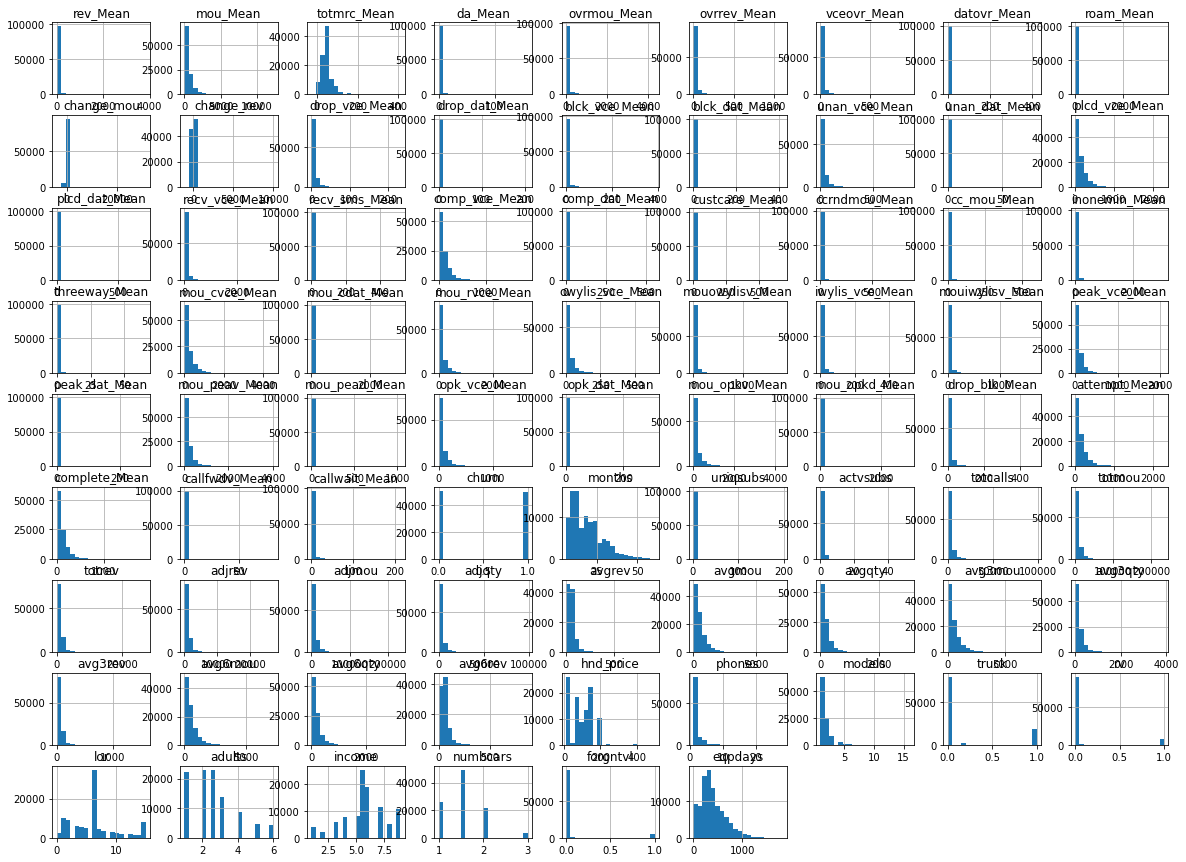

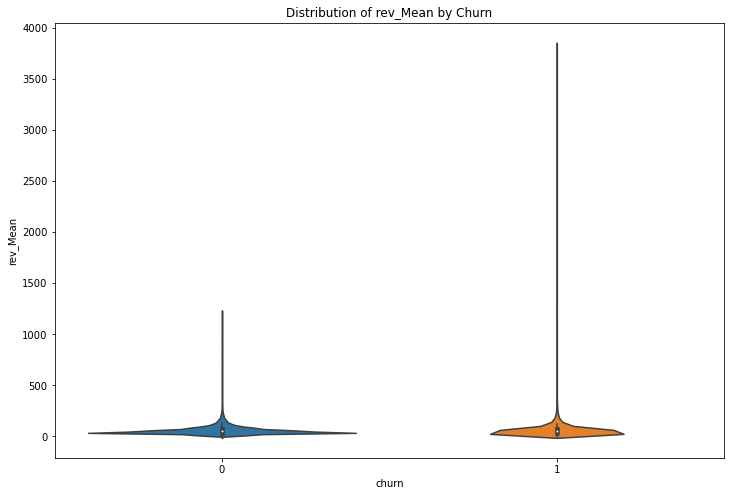

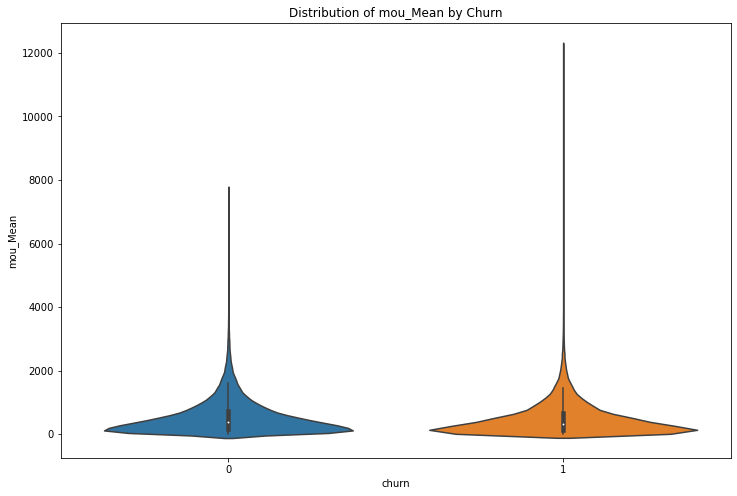

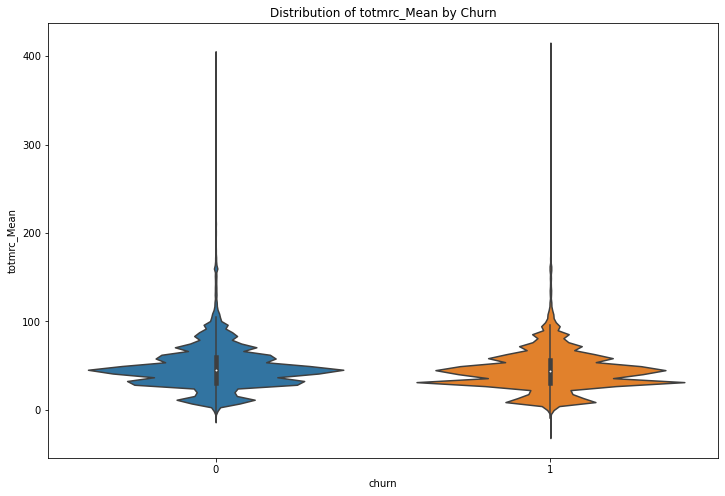

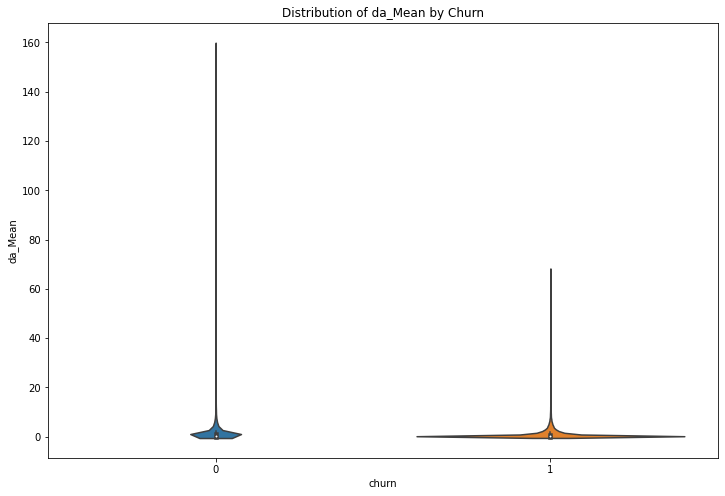

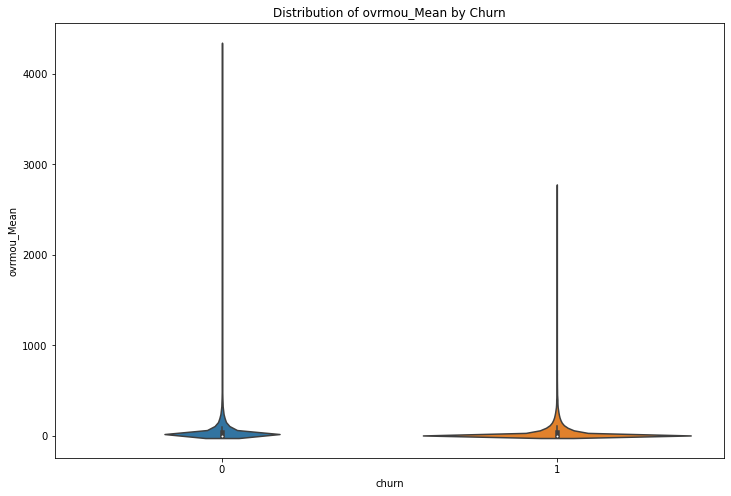

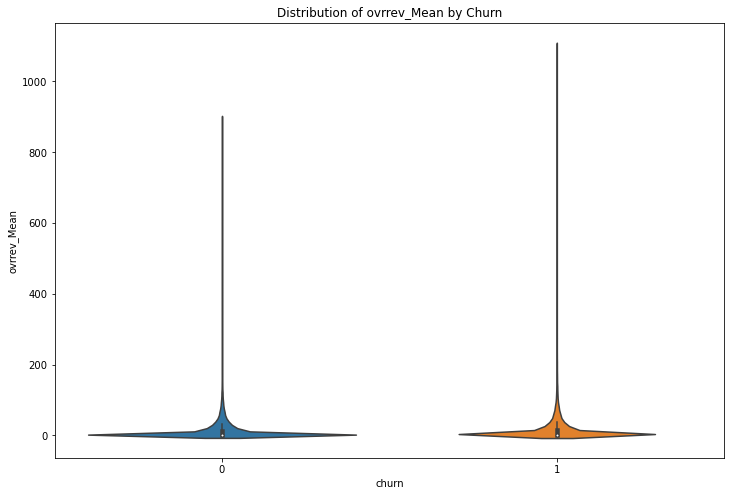

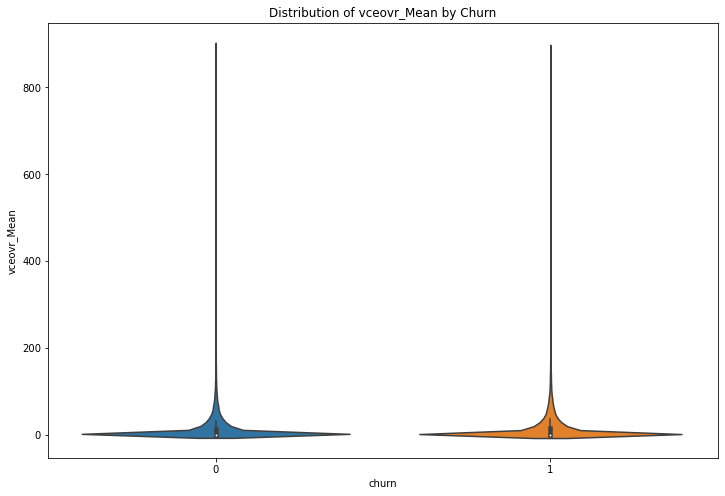

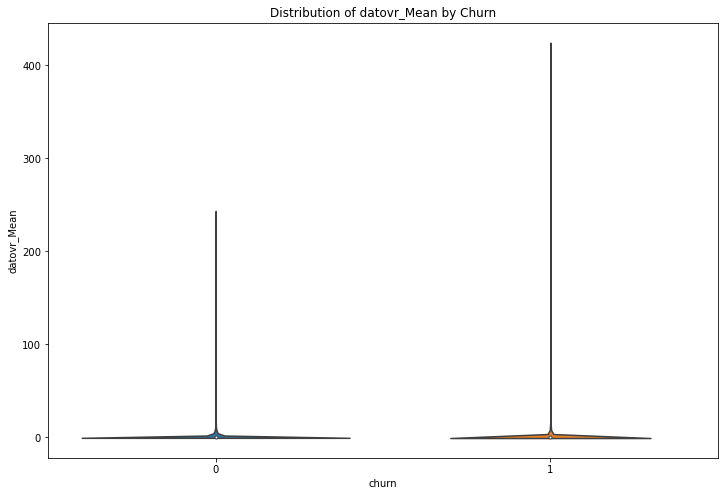

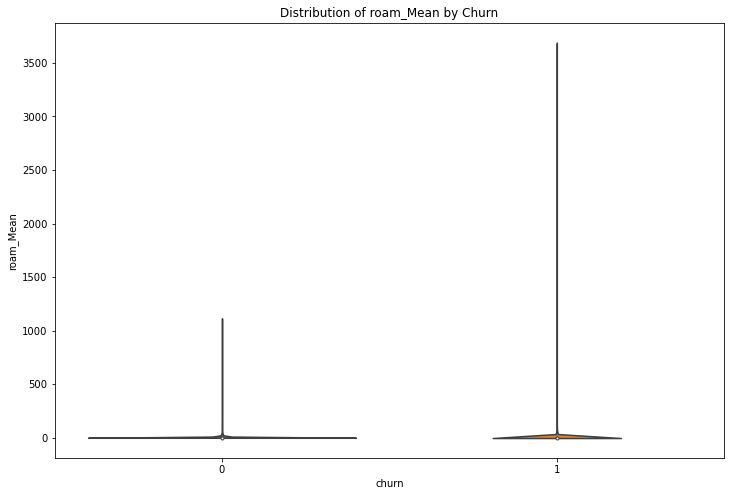

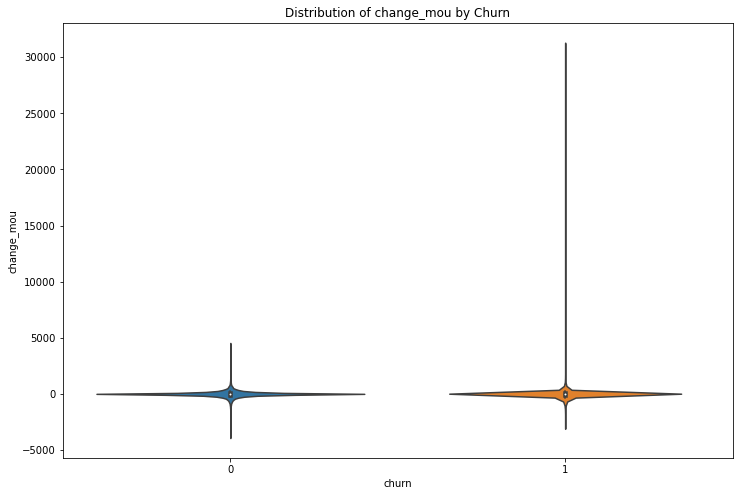

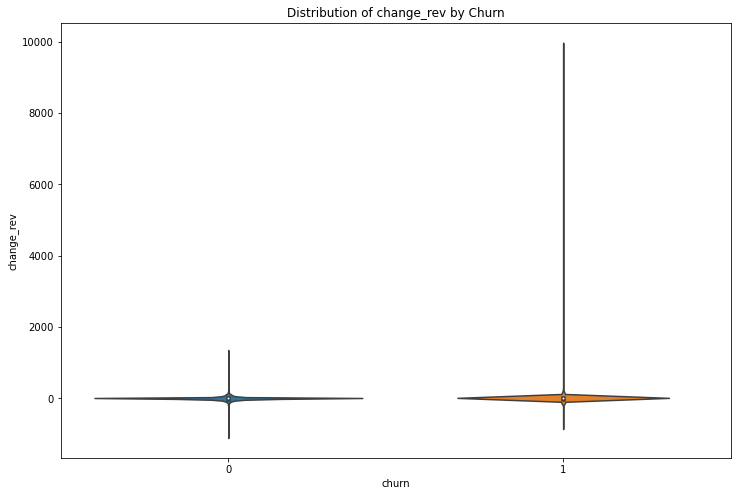

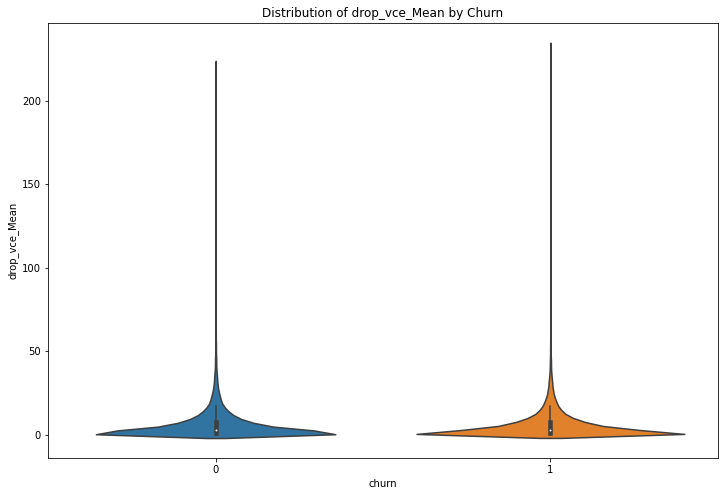

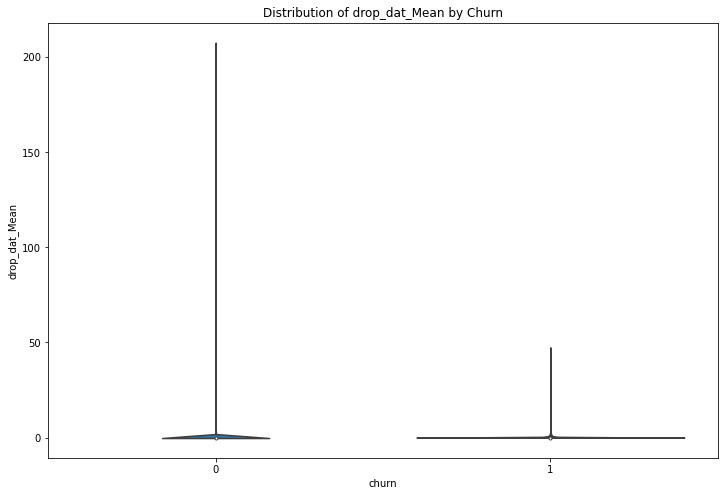

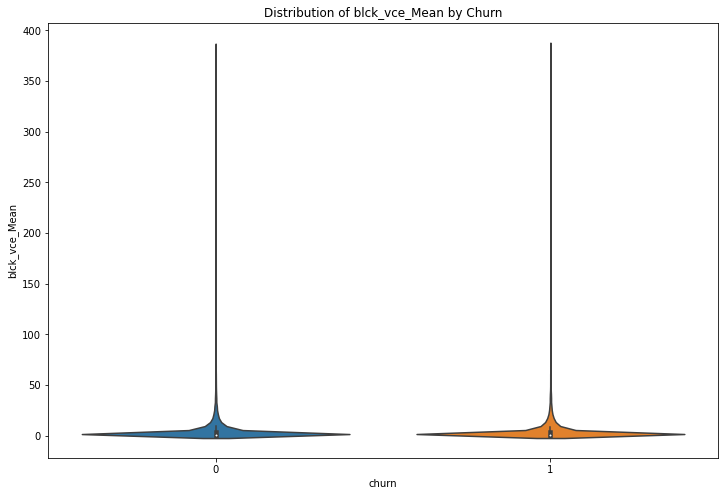

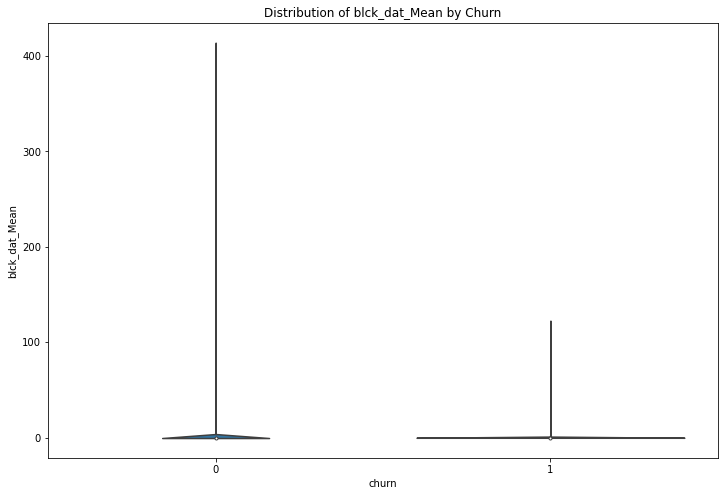

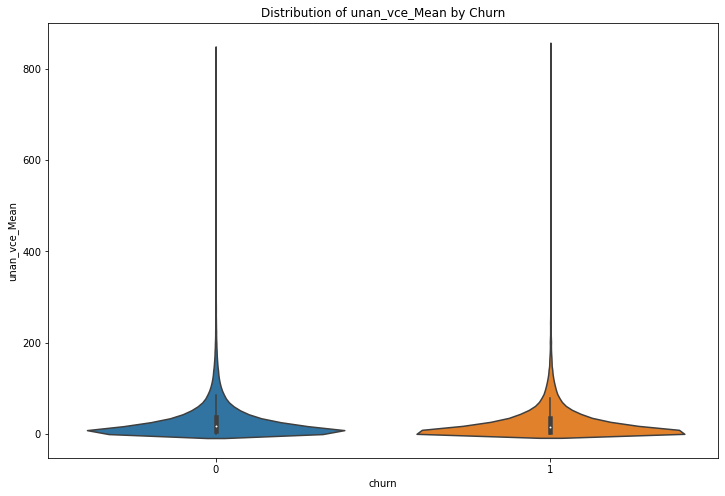

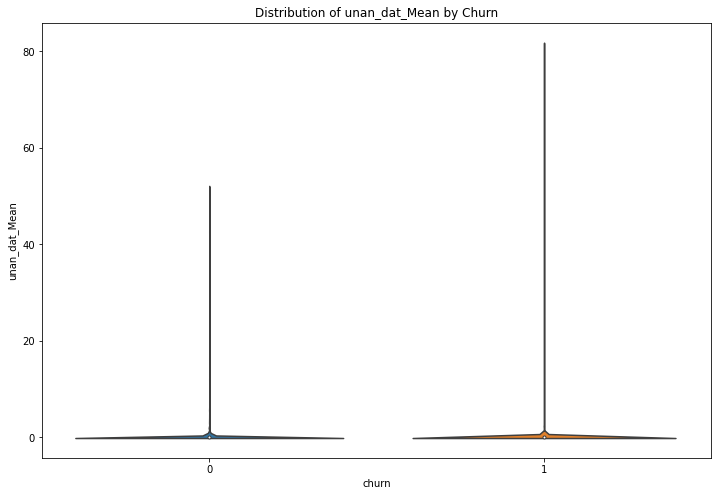

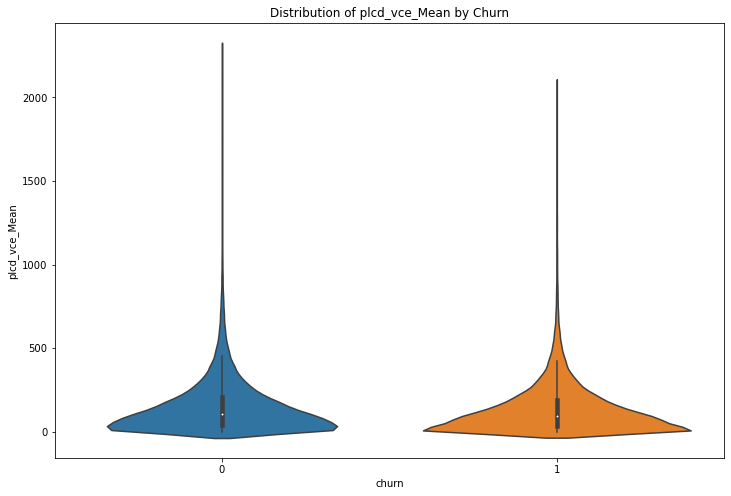

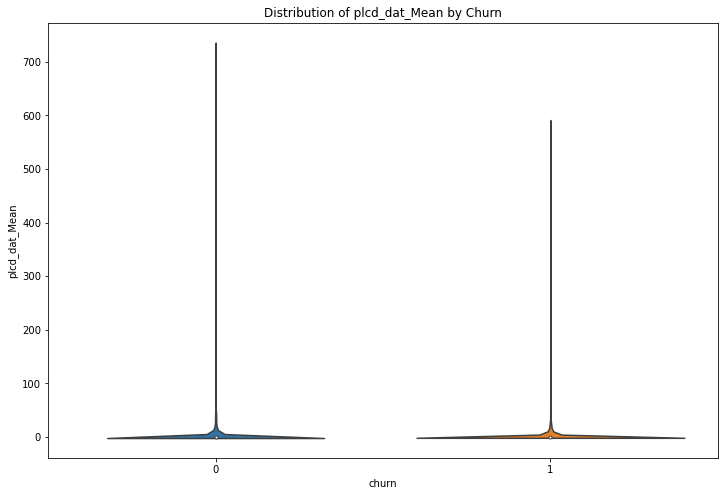

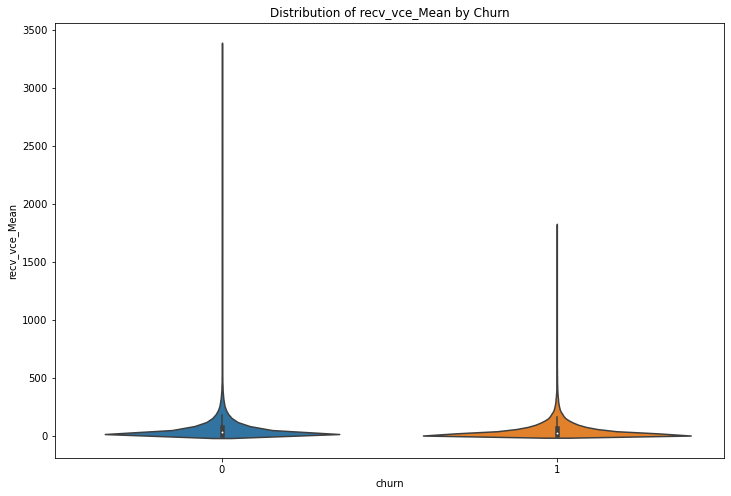

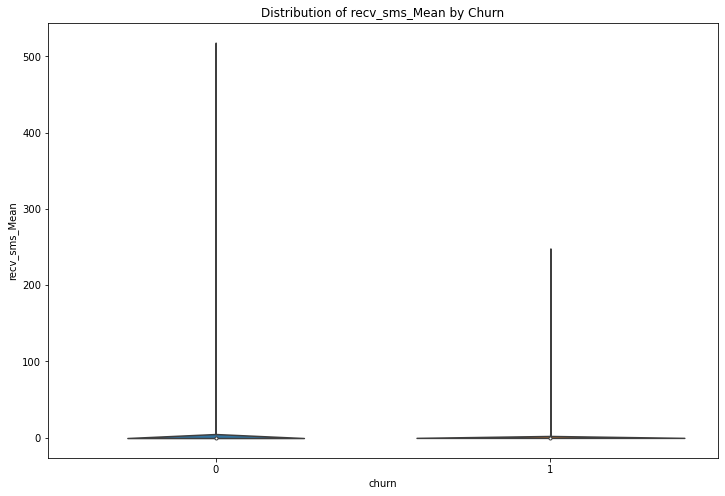

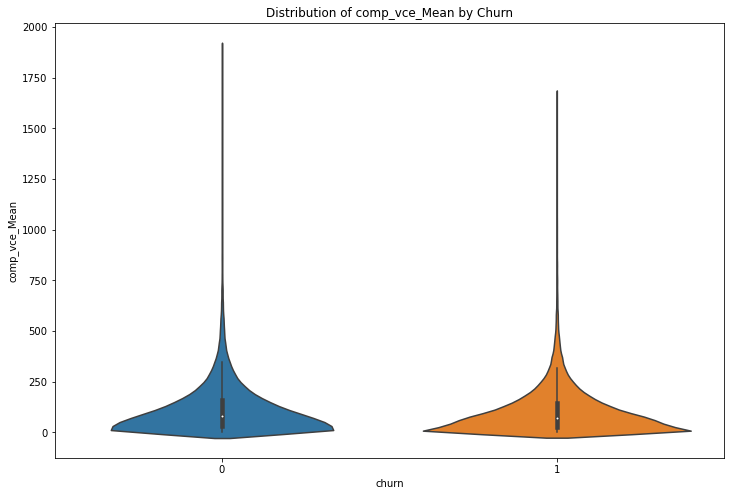

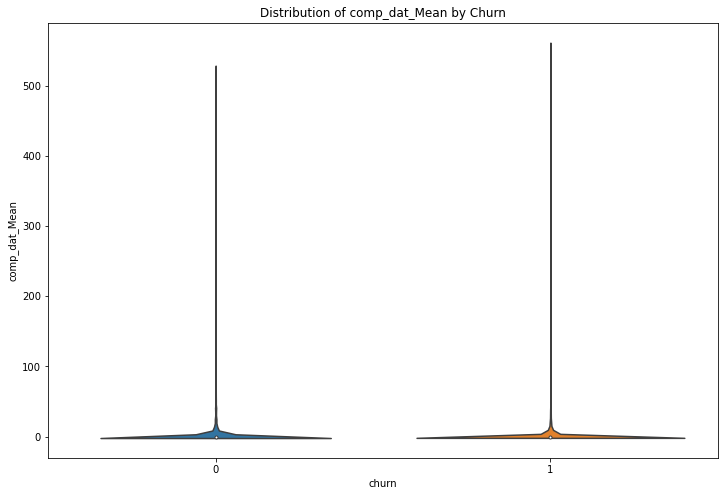

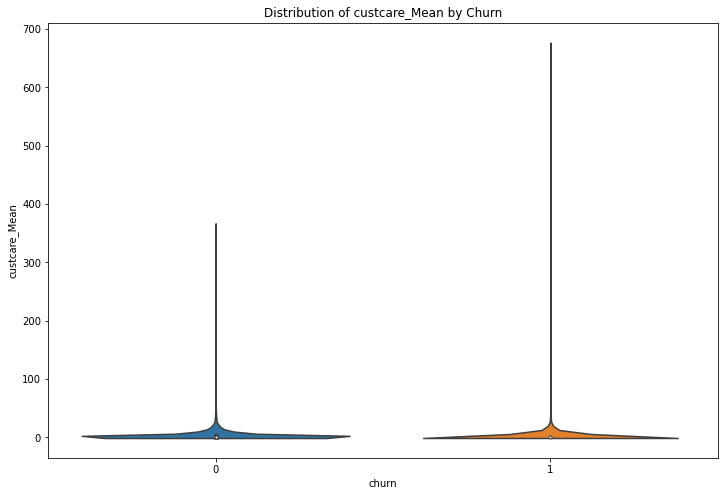

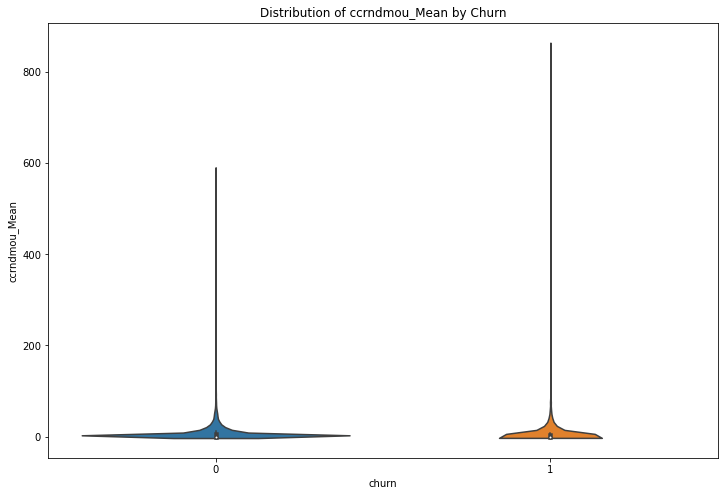

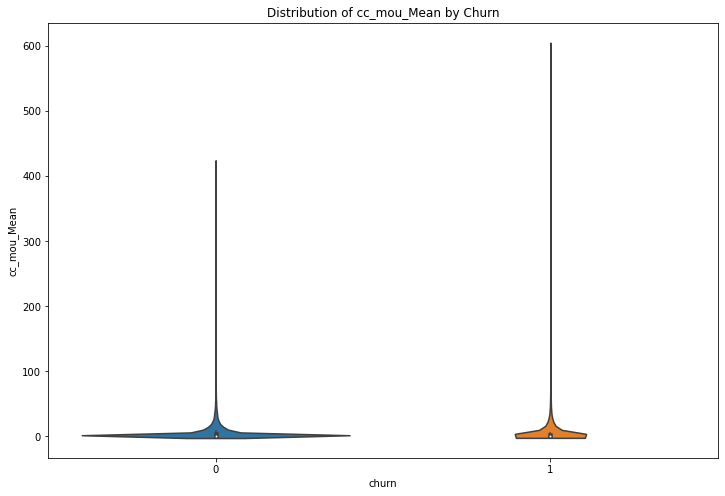

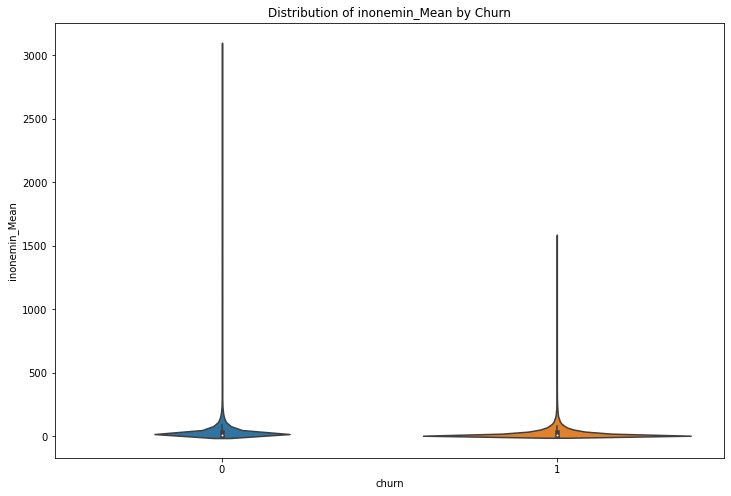

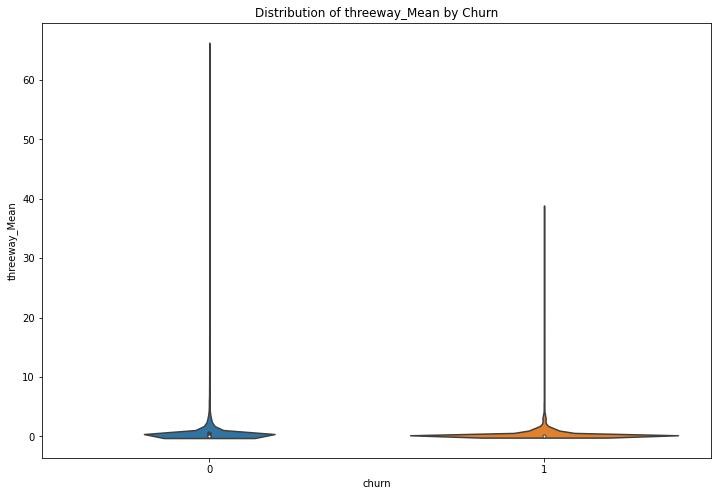

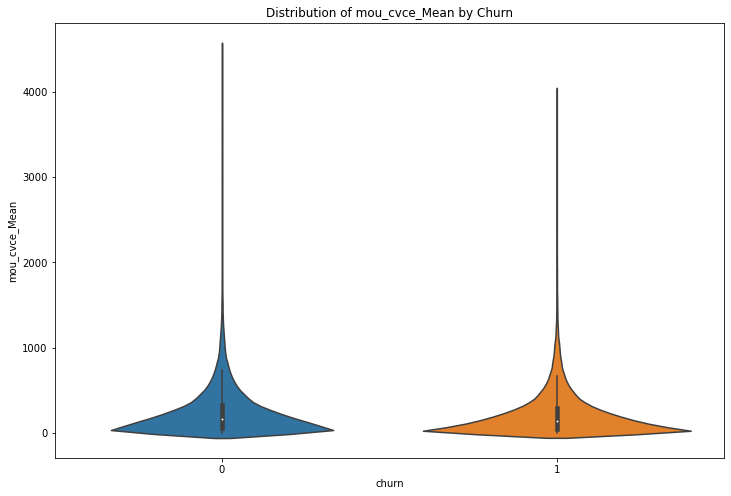

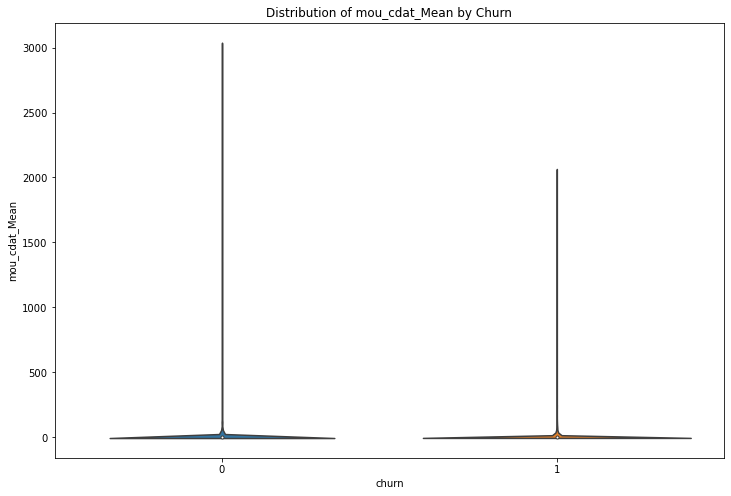

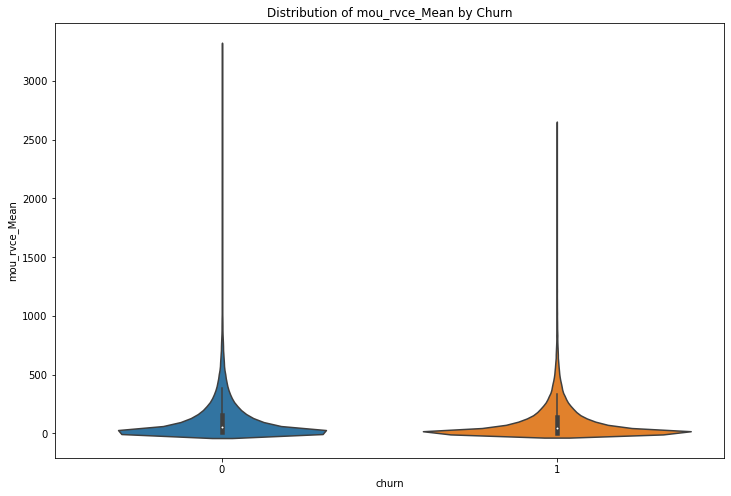

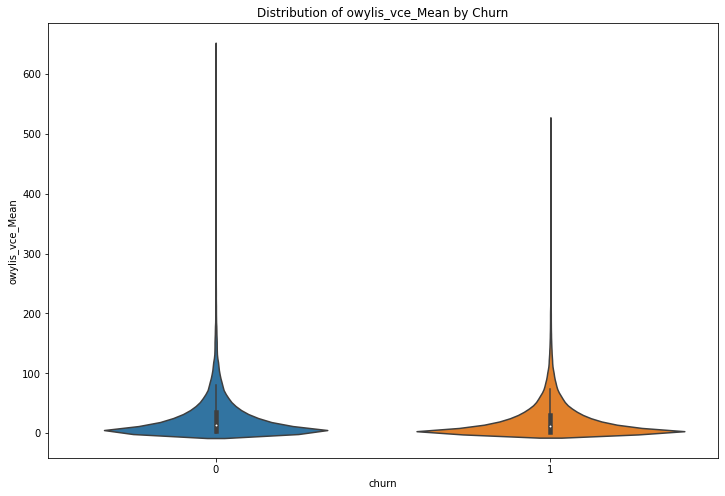

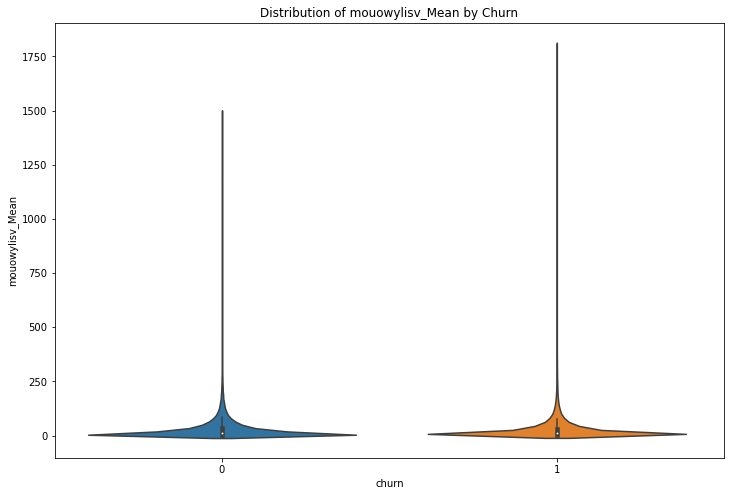

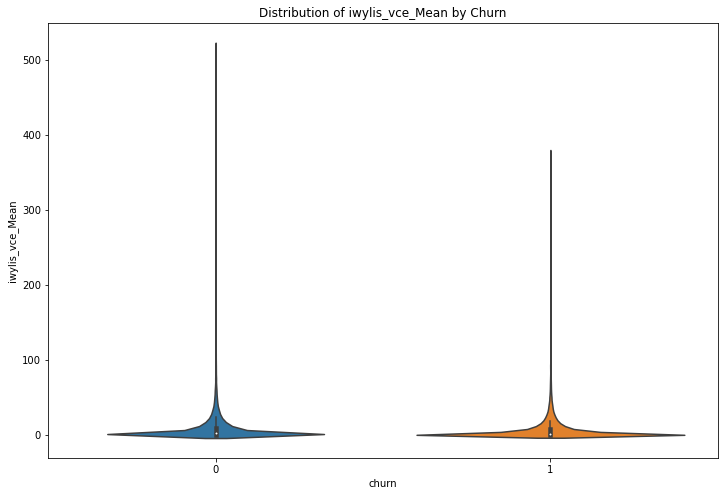

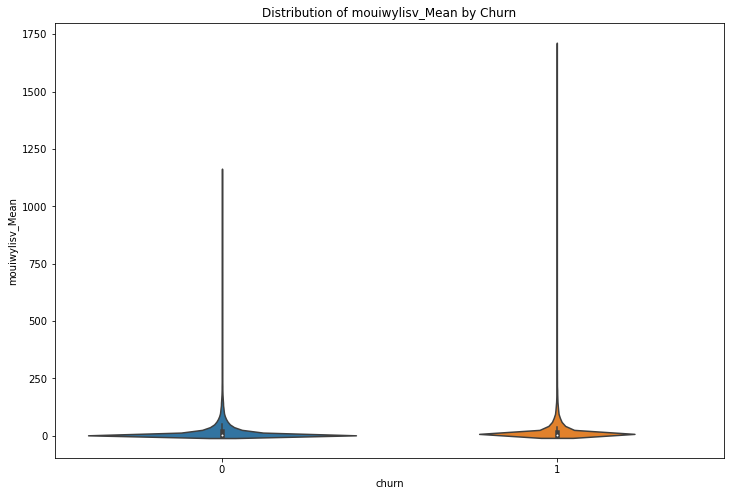

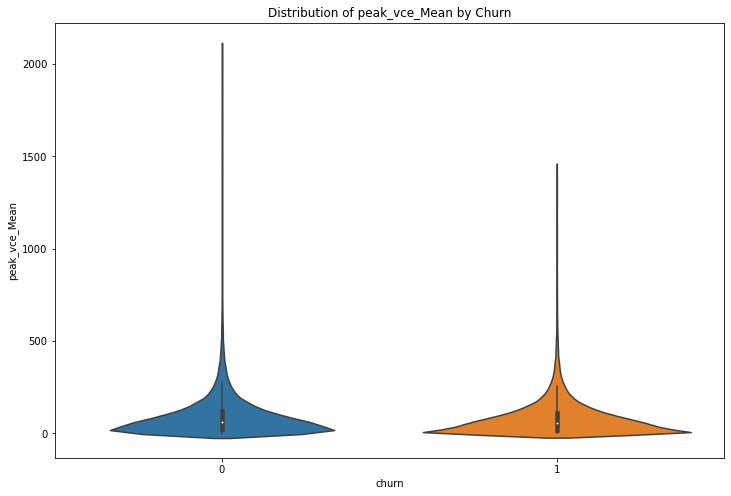

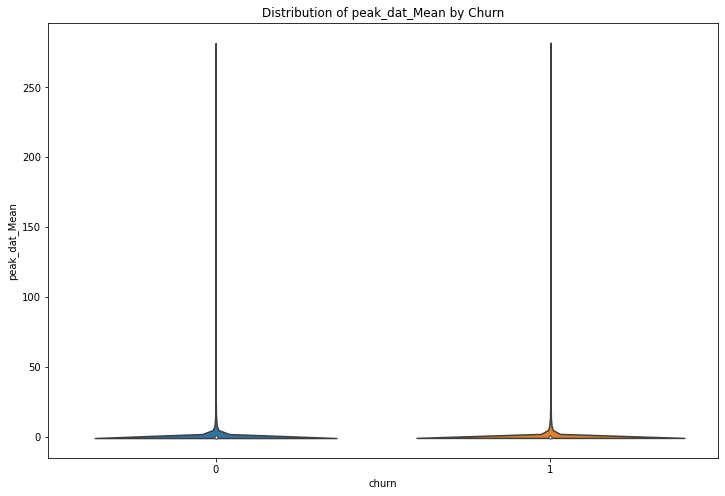

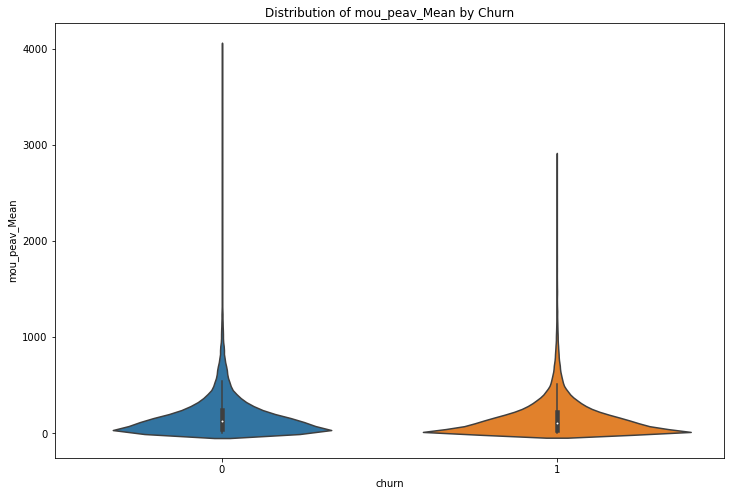

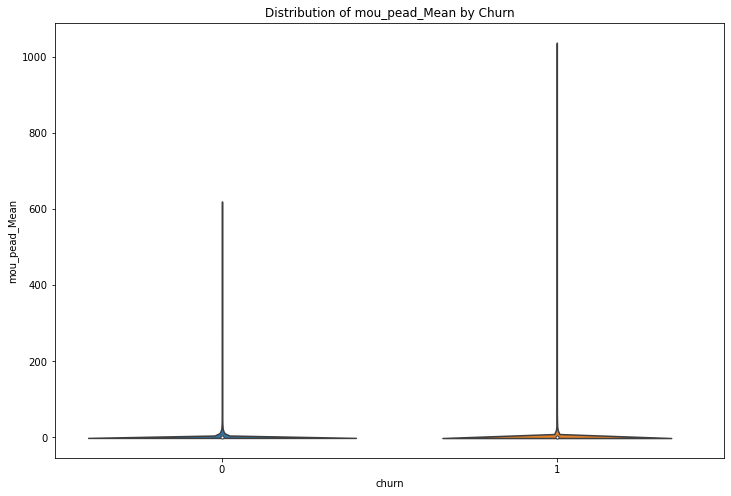

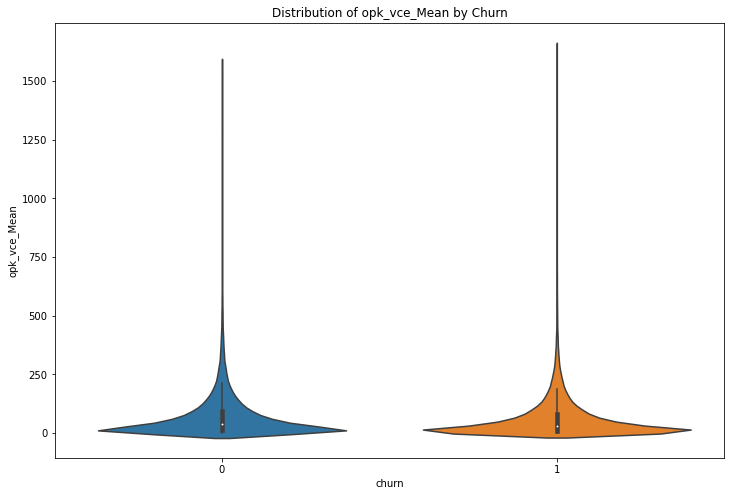

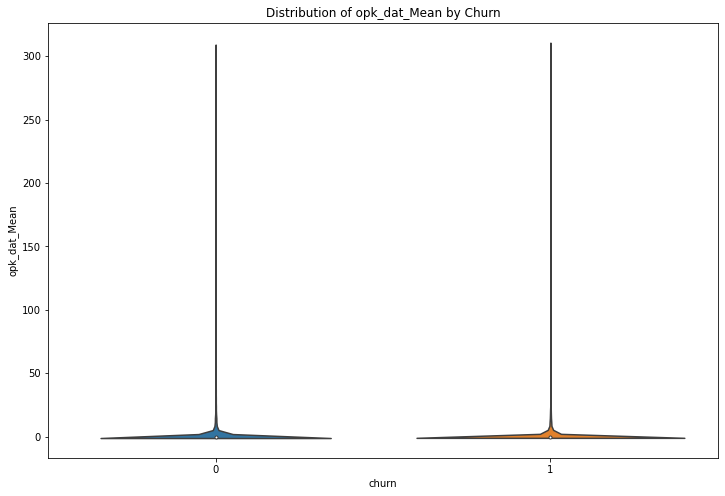

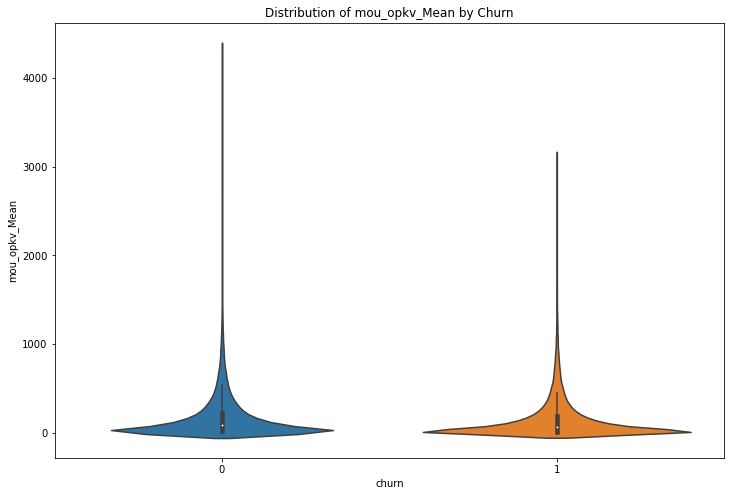

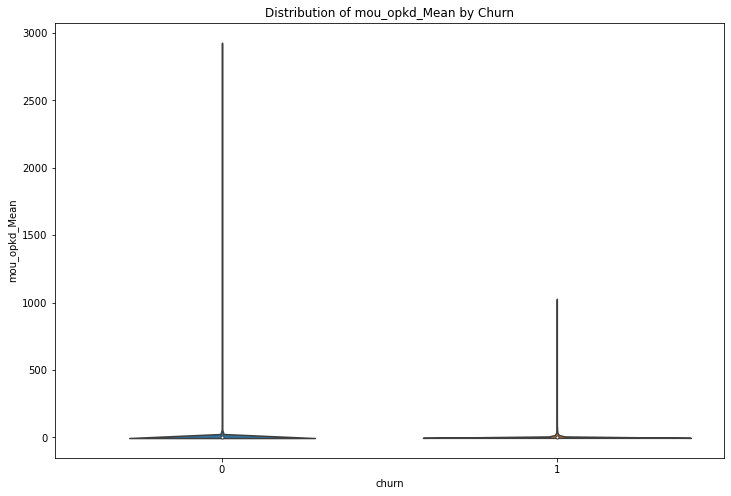

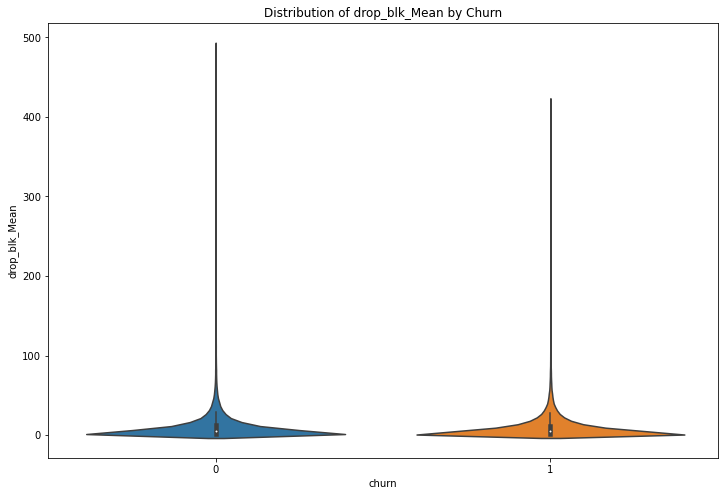

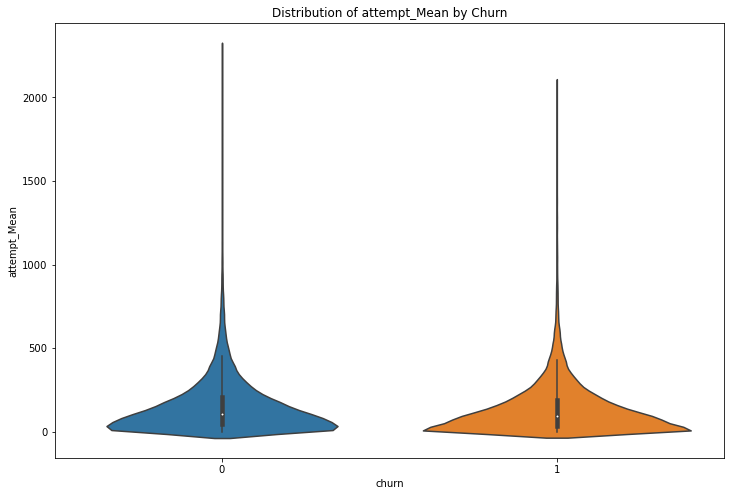

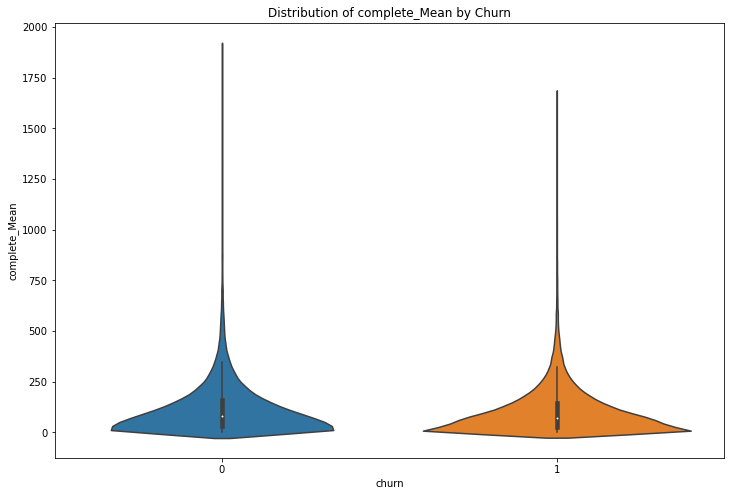

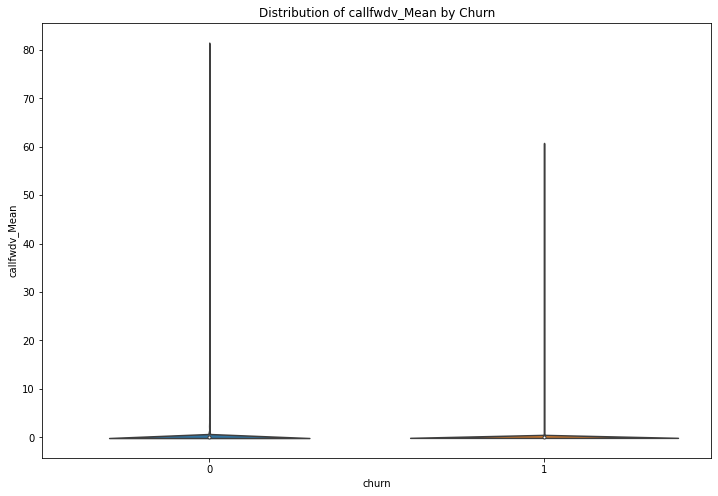

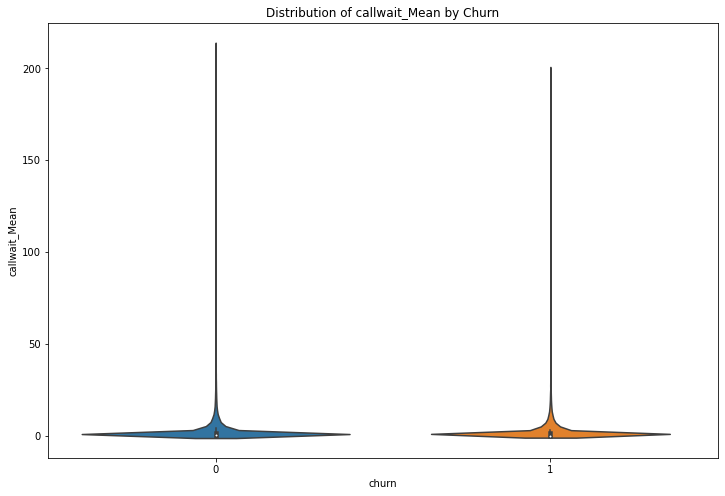

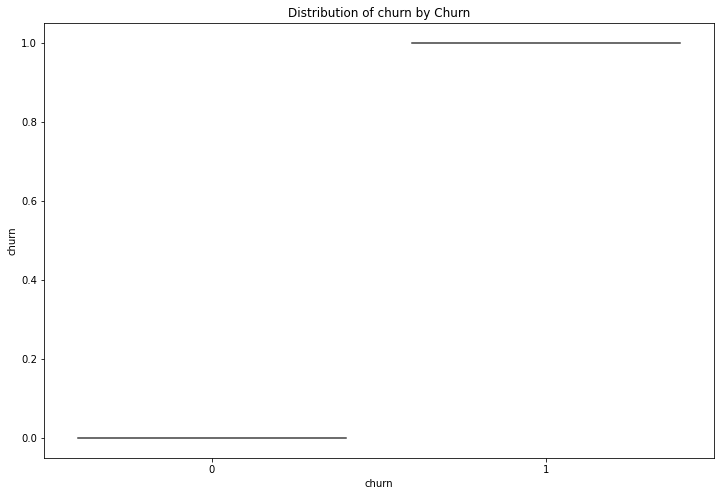

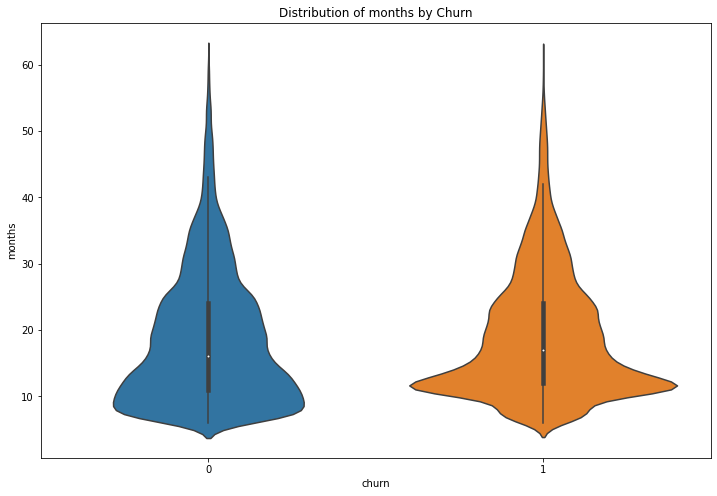

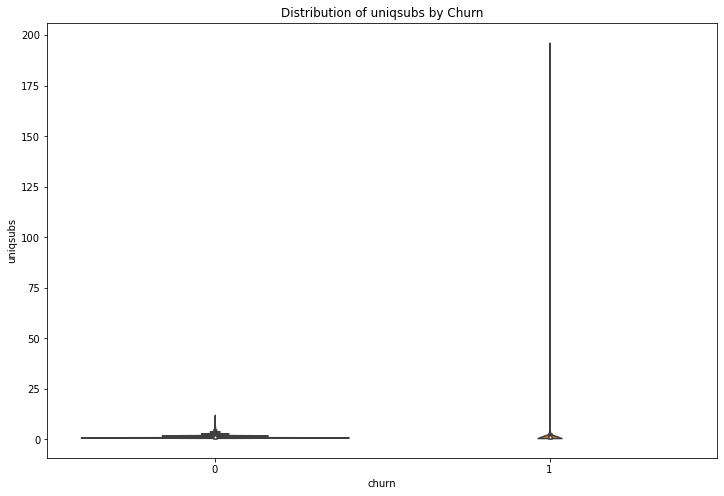

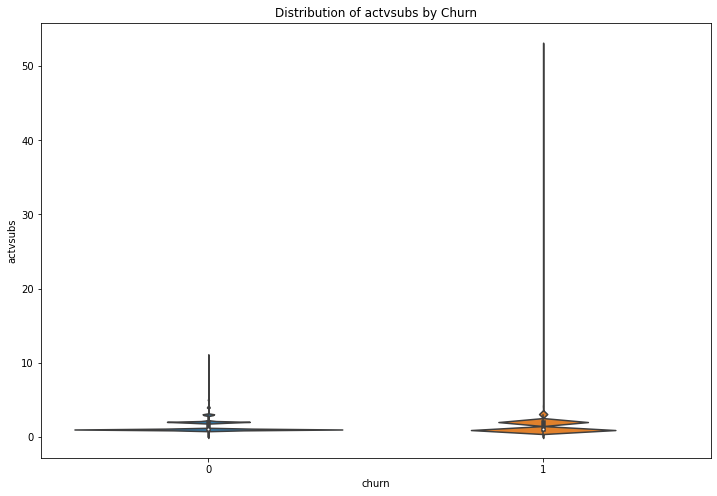

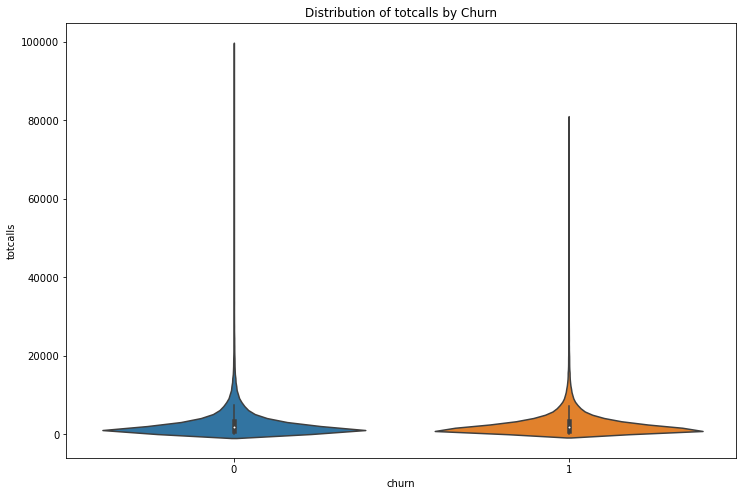

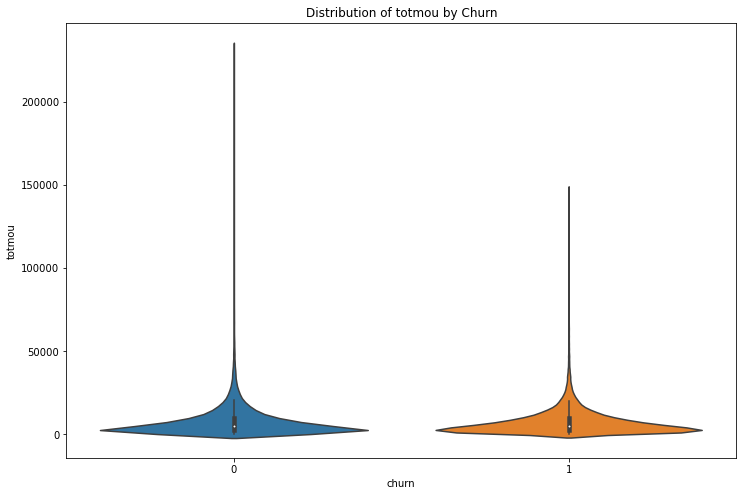

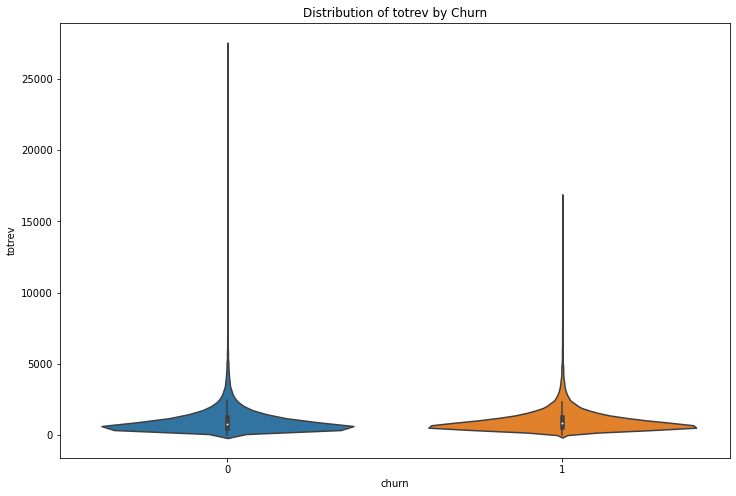

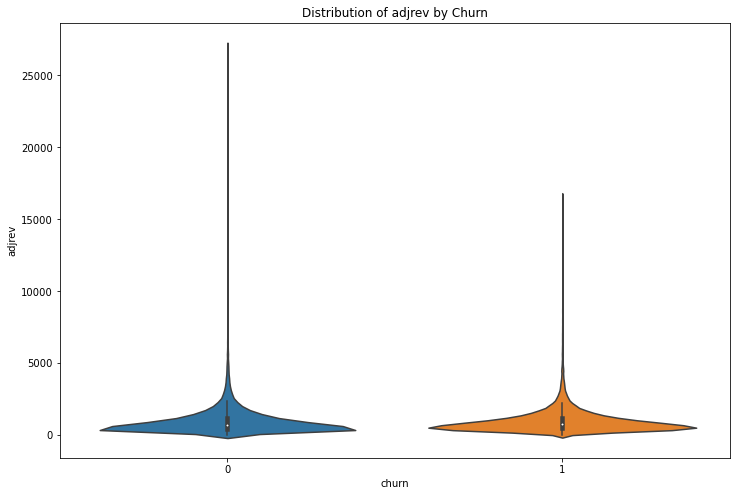

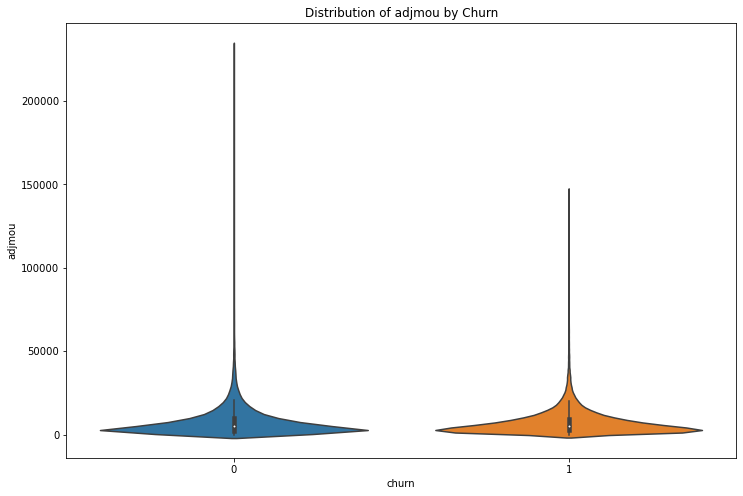

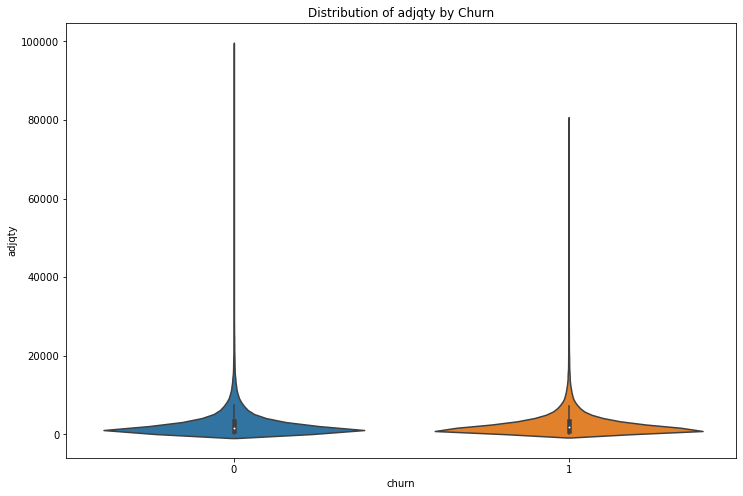

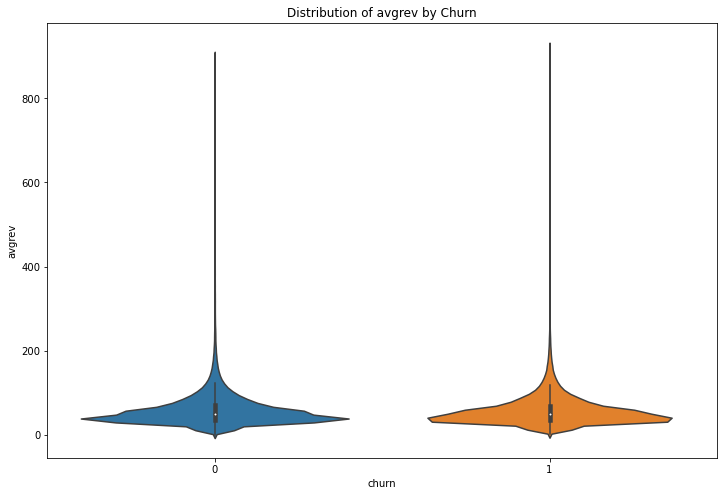

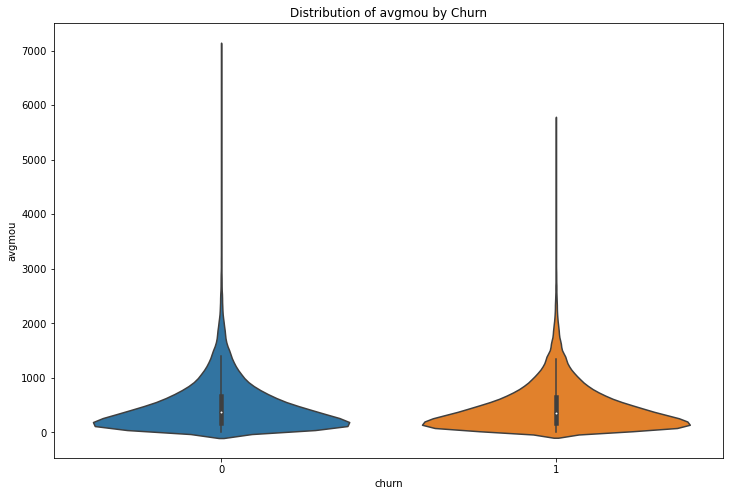

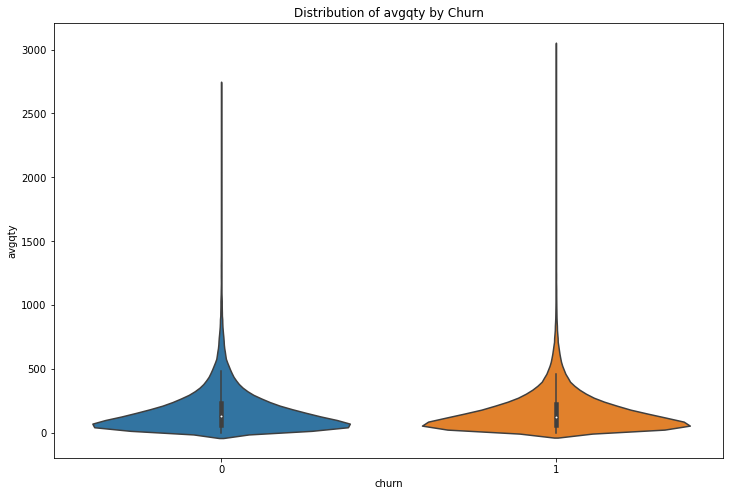

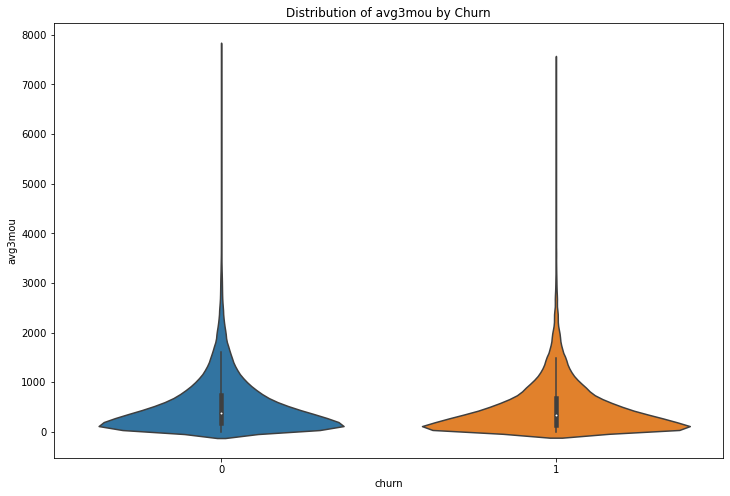

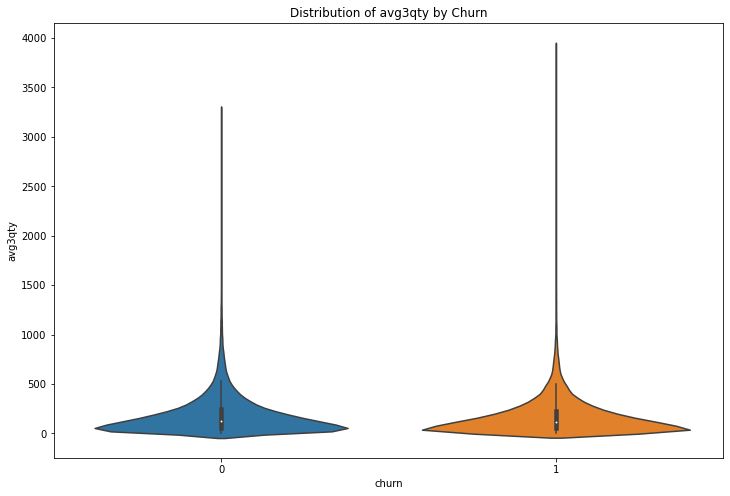

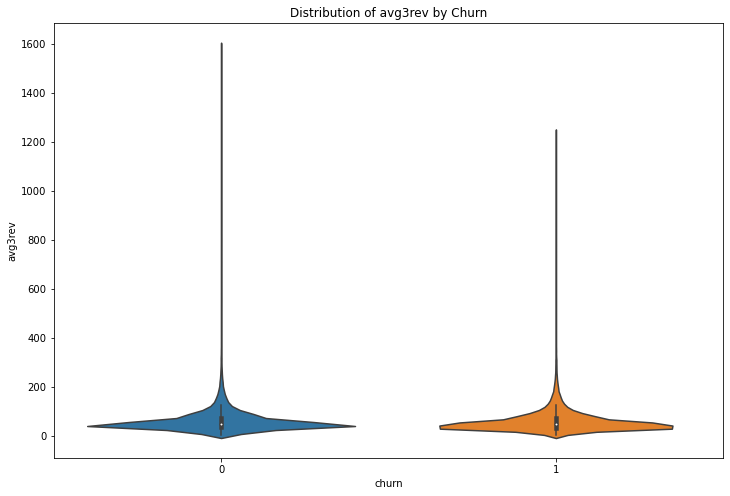

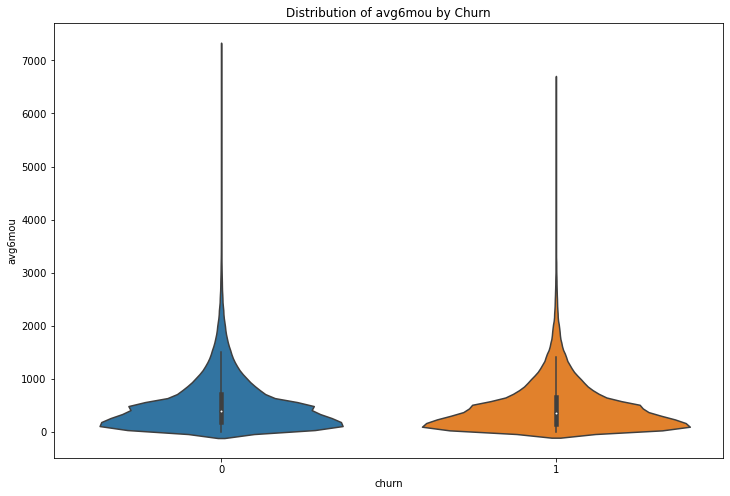

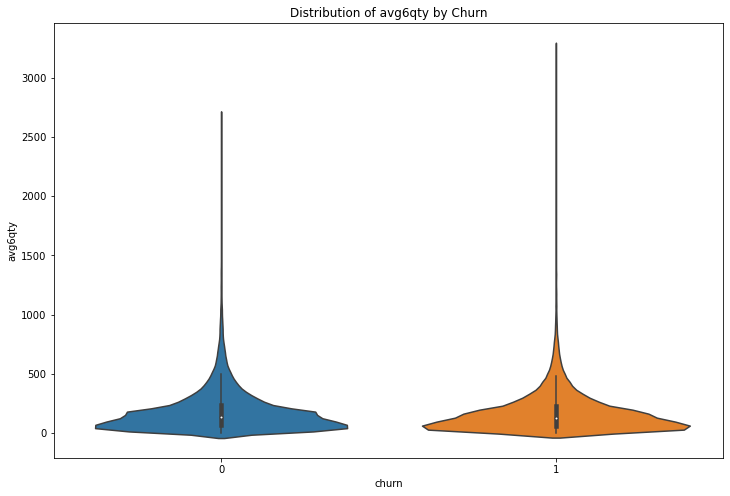

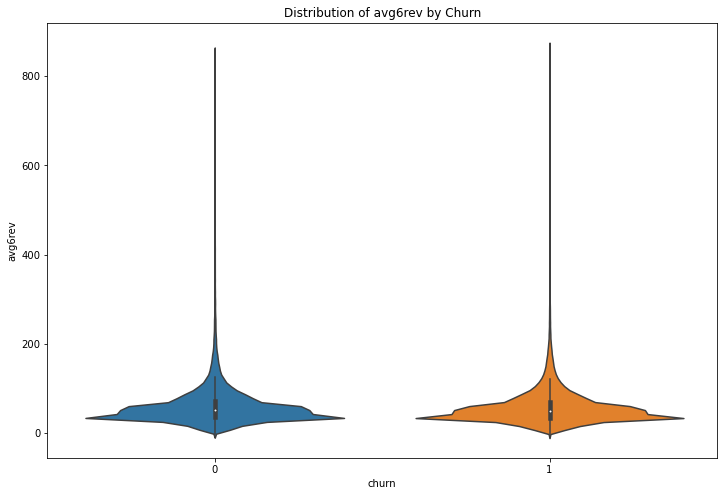

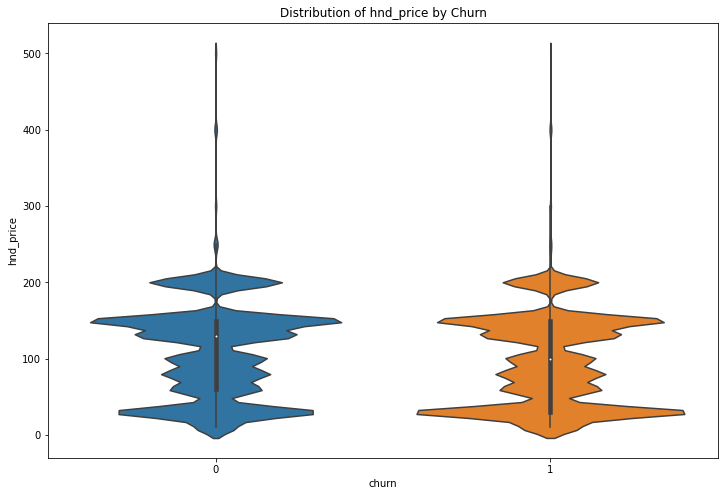

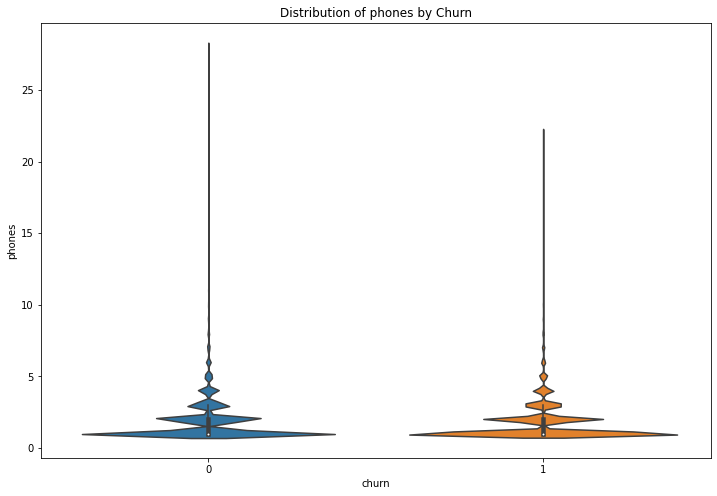

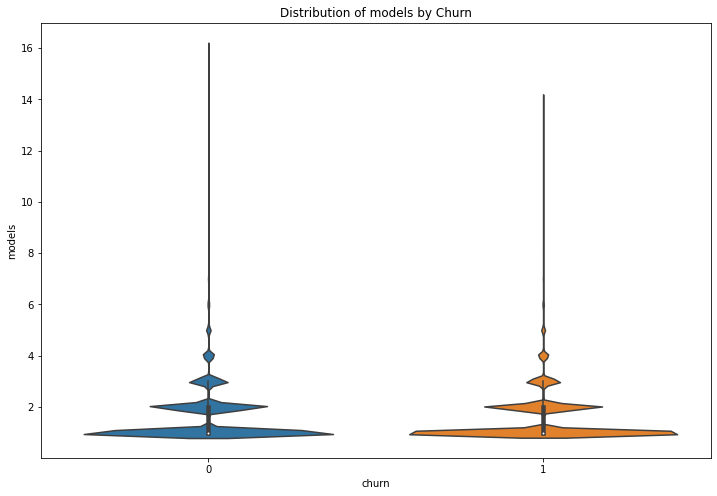

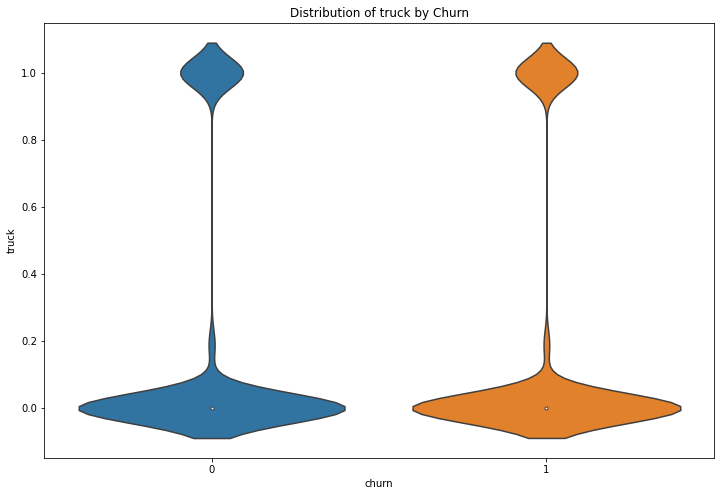

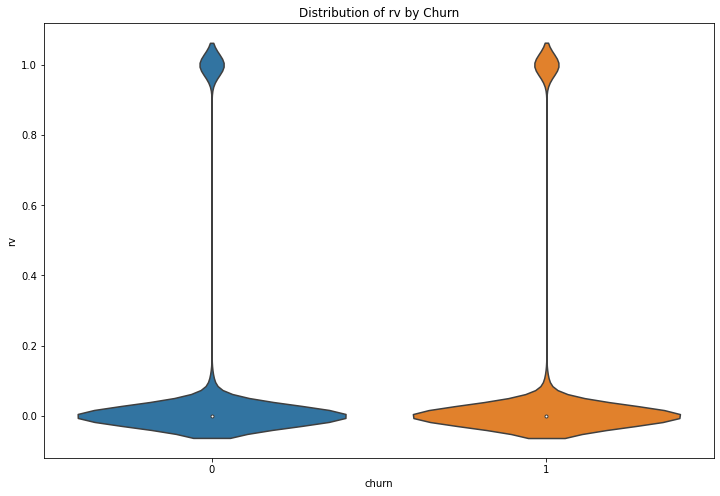

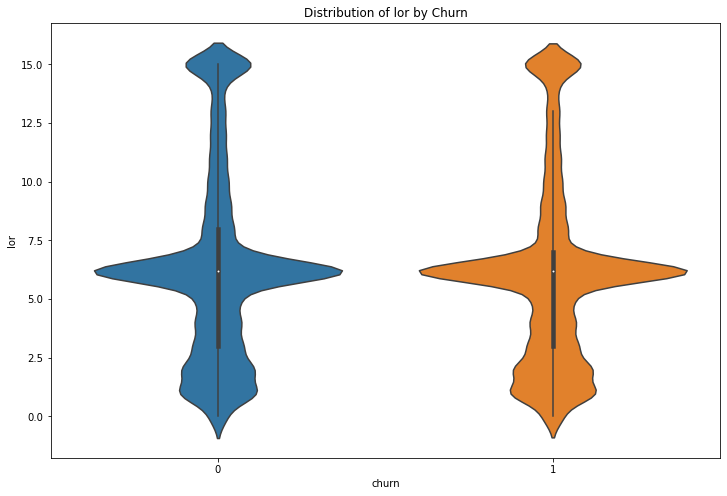

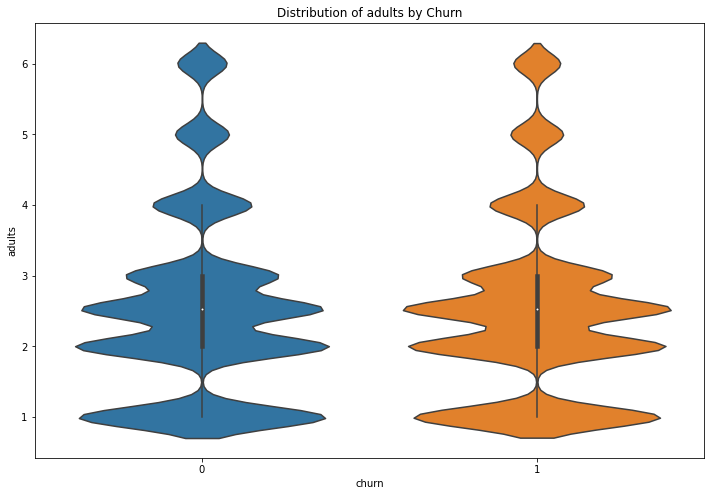

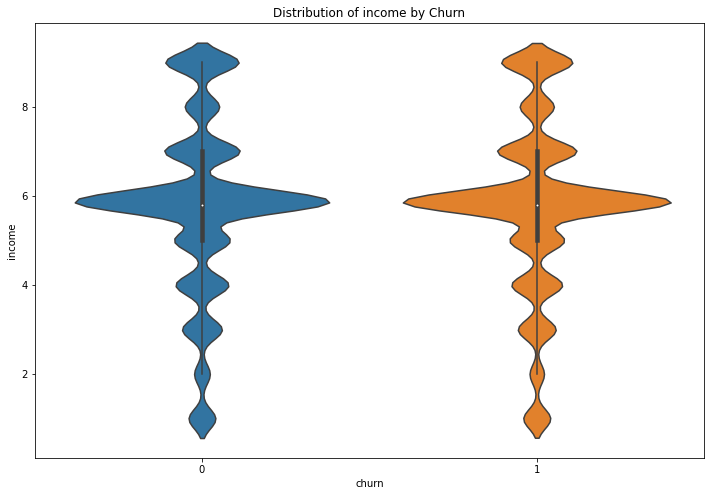

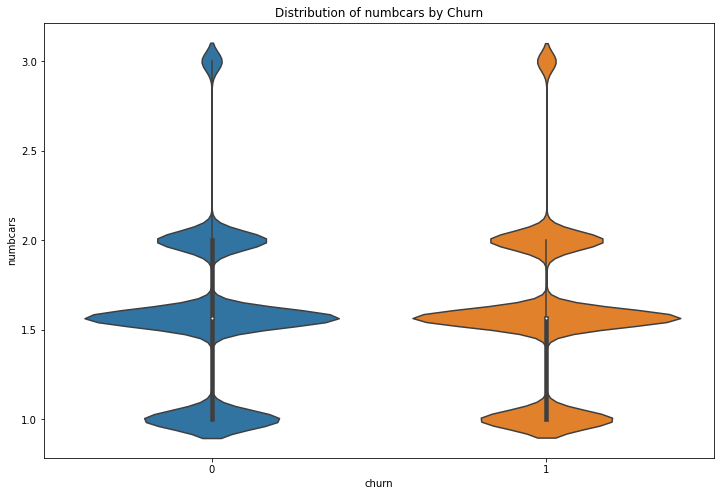

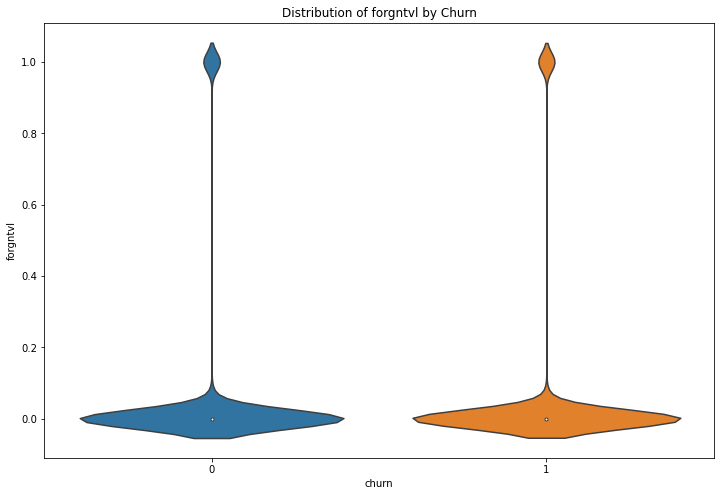

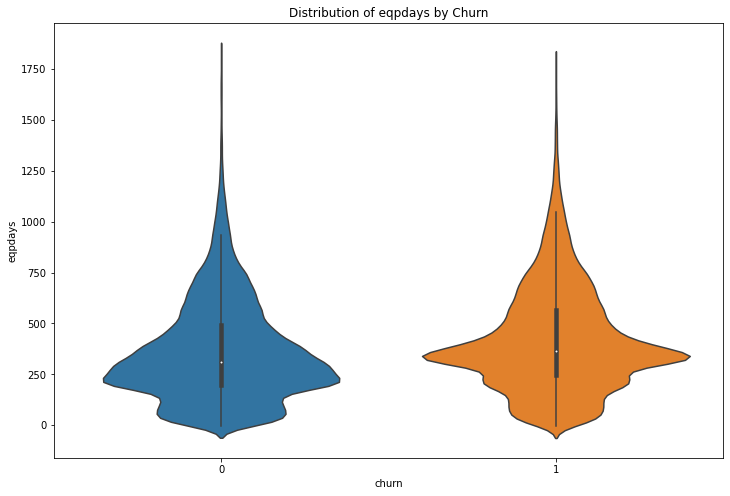

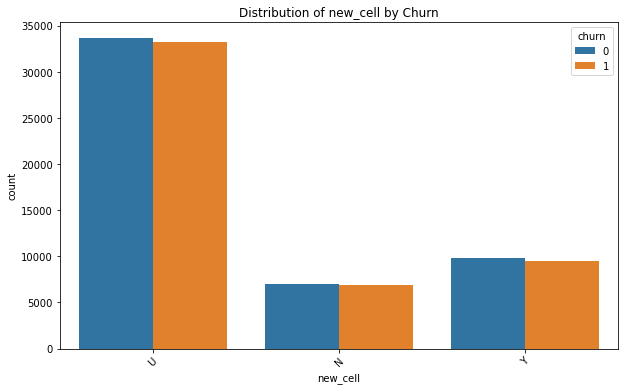

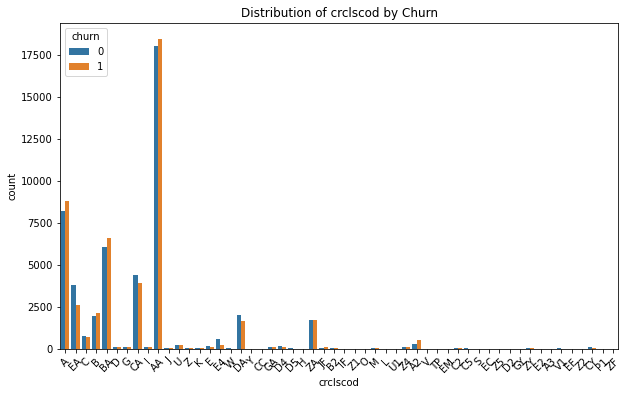

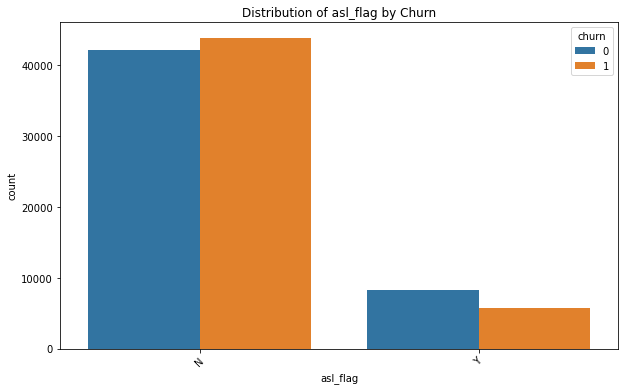

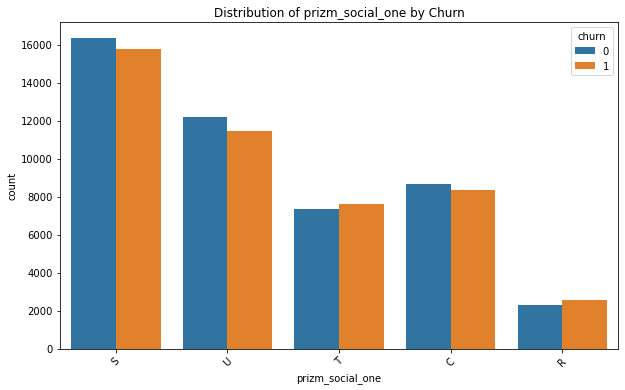

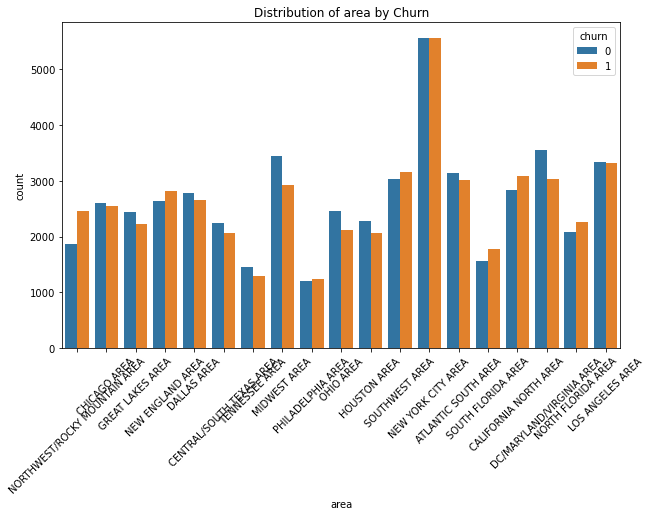

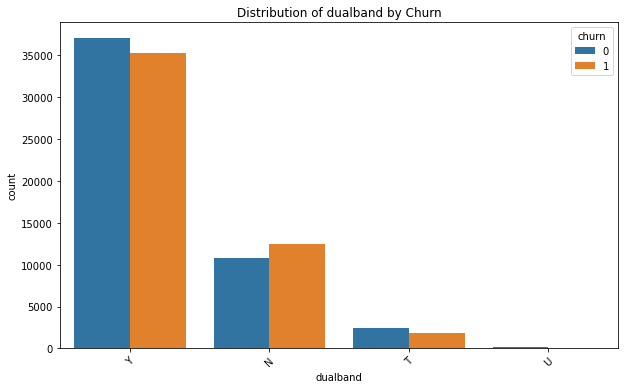

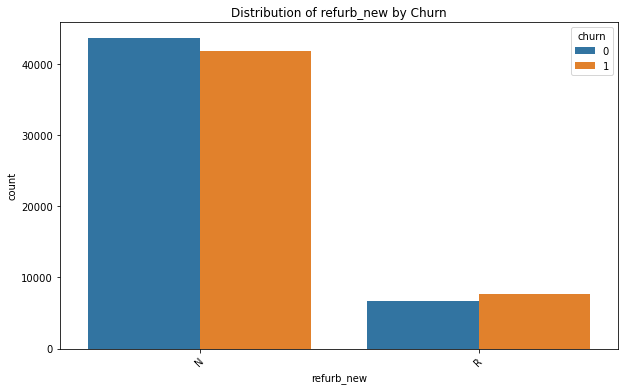

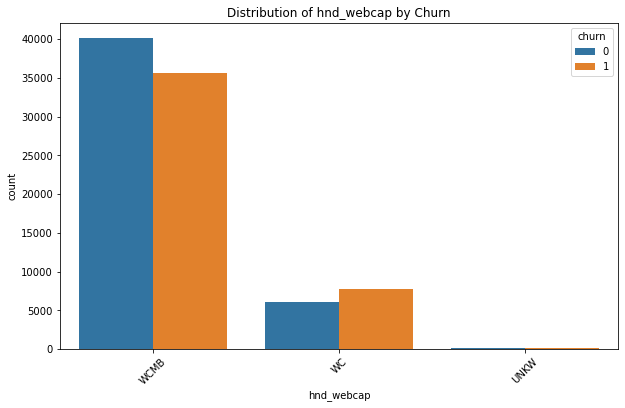

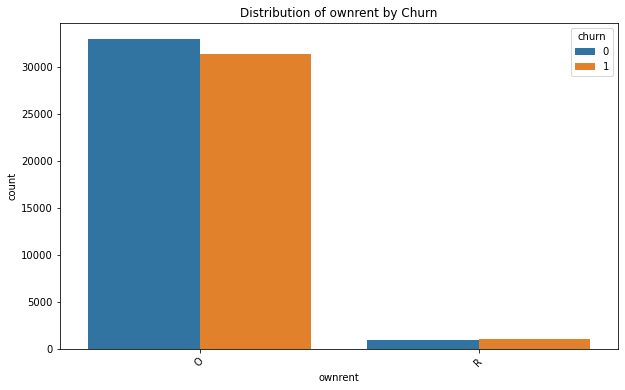

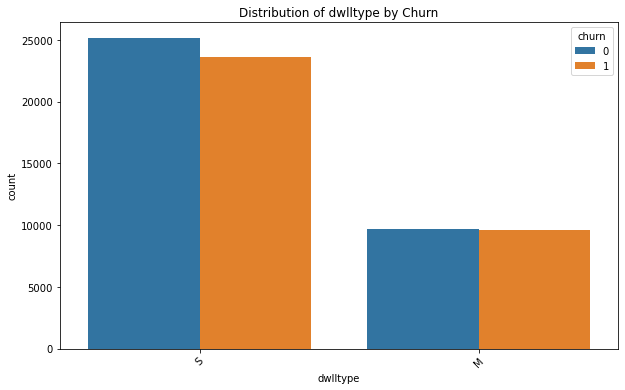

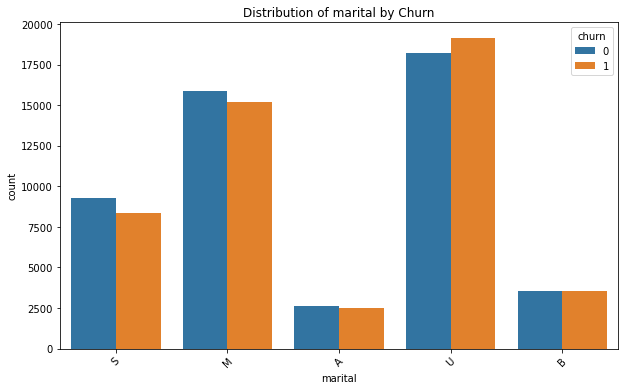

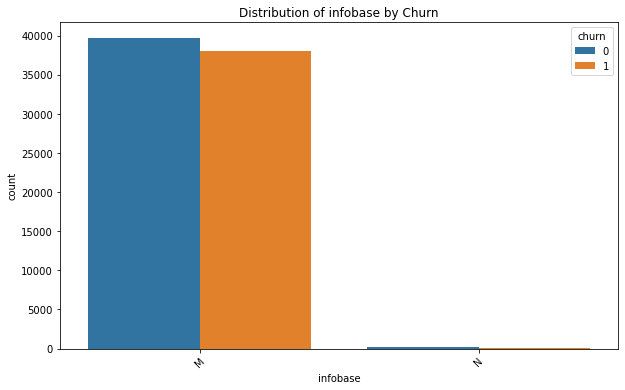

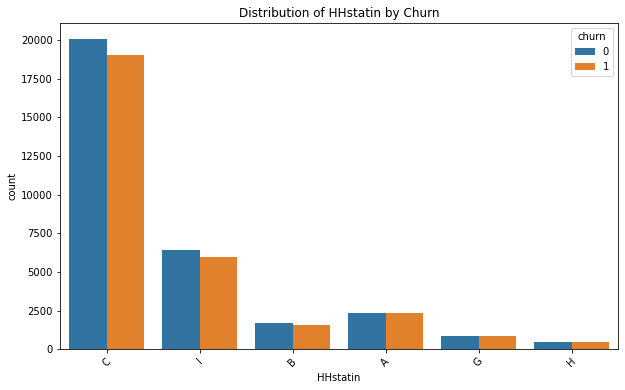

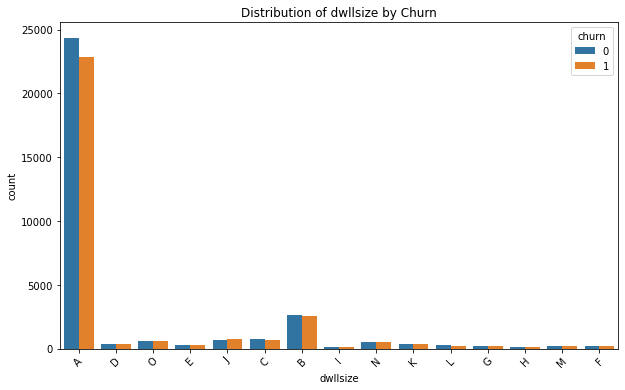

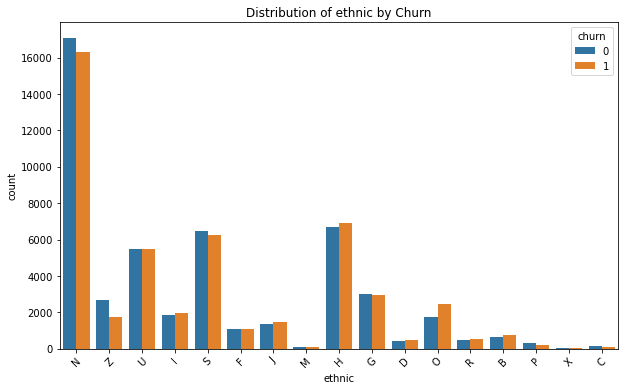

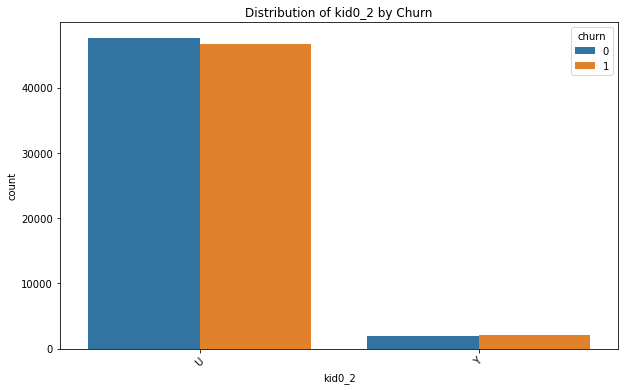

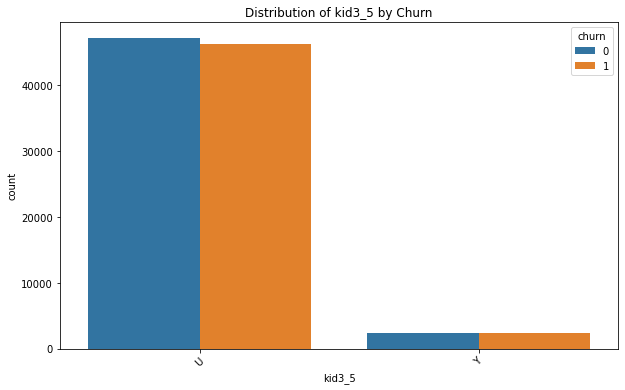

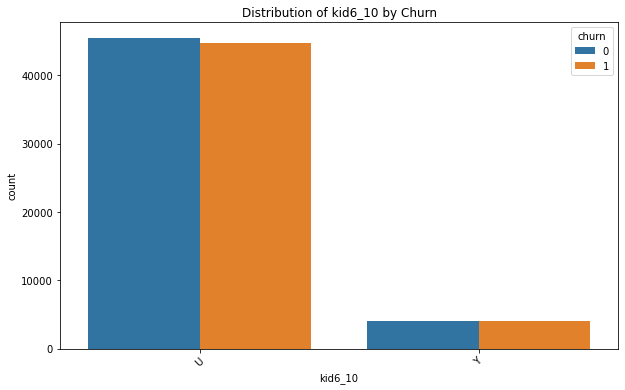

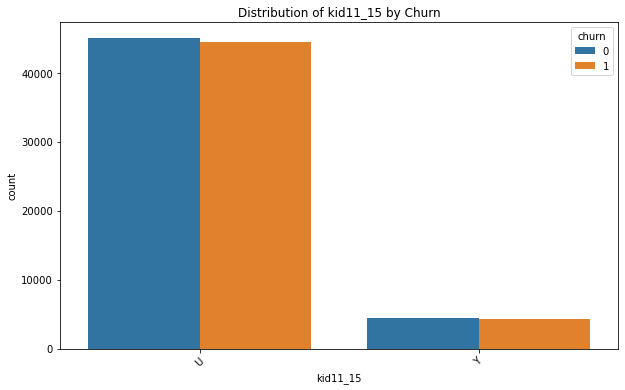

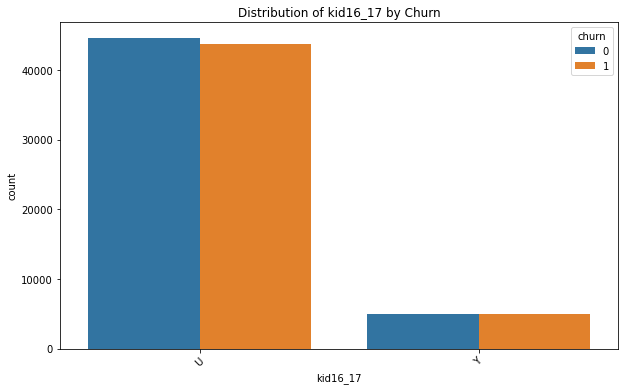

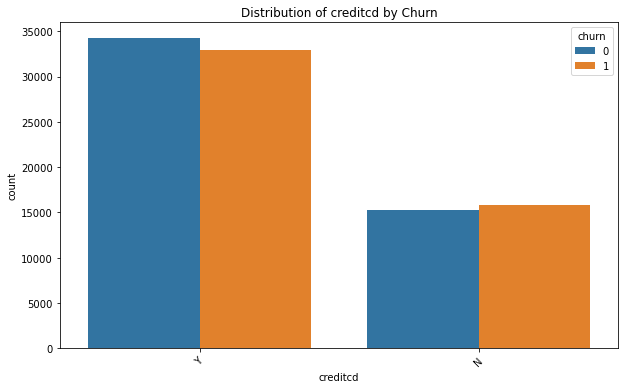

In [7]:
df.hist(bins=20, figsize=(20, 15))
plt.show()

# Box plots for numerical variables vs churn
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
# Generate box plots
for col in numerical_columns:
    plt.figure(figsize=(12, 8))  # Adjust figure size to make individual plots clearer
    sns.violinplot(x='churn', y=col, data=df)
    plt.title(f'Distribution of {col} by Churn')
    plt.show()

# Count plots for categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns

# Now create count plots for each categorical column
for col in categorical_cols:
    plt.figure(figsize=(10, 6))  # Adjust figsize to ensure the plot is large enough to be clear
    sns.countplot(x=col, hue='churn', data=df)
    plt.title(f'Distribution of {col} by Churn')
    plt.xticks(rotation=45)  # Rotate labels if they overlap or are too long
    plt.show()

In [8]:
#Change my categorical features to numerical format so that they can be used in the models.
categorical_col = [col for col in df.columns if df[col].dtype == 'object']
le = LabelEncoder()
for col in categorical_col:
    df[col] = le.fit_transform(df[col].astype(str))
X = df.drop('churn', axis = 1)
y = df['churn']

## Model Building

In [9]:
# Split with all features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
importances = model.feature_importances_

# Organize the feature importances into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)

             Feature  Importance
97           eqpdays    0.034726
9         change_mou    0.025463
48            months    0.025026
10        change_rev    0.020503
1           mou_Mean    0.020409
57            adjrev    0.019921
62            avgqty    0.019443
56            totrev    0.019414
60            avgrev    0.019352
61            avgmou    0.019192
0           rev_Mean    0.018743
54          totcalls    0.018331
55            totmou    0.018319
58            adjmou    0.018194
59            adjqty    0.018161
63           avg3mou    0.018157
28     mou_cvce_Mean    0.017254
37     mou_peav_Mean    0.017213
41     mou_opkv_Mean    0.017186
66           avg6mou    0.017177
64           avg3qty    0.016869
2        totmrc_Mean    0.016348
67           avg6qty    0.016209
32   mouowylisv_Mean    0.016122
30     mou_rvce_Mean    0.015883
35     peak_vce_Mean    0.015460
15     unan_vce_Mean    0.015295
39      opk_vce_Mean    0.015217
68           avg6rev    0.015066
65        

In [11]:
#dropping all features below 25th percentile
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})
threshold = features['Importance'].quantile(0.25)
to_drop = features[features['Importance'] < threshold]['Feature']
X_train_reduced = X_train.drop(columns=to_drop)
X_test_reduced = X_test.drop(columns=to_drop)

# Re-train the model to compare performance
model.fit(X_train_reduced, y_train)
predictions = model.predict(X_test_reduced)
new_accuracy = accuracy_score(y_test, predictions)

print("New Accuracy: ", new_accuracy)
print("Dropped Features: ", list(to_drop))

New Accuracy:  0.6222
Dropped Features:  ['drop_dat_Mean', 'blck_dat_Mean', 'unan_dat_Mean', 'plcd_dat_Mean', 'recv_sms_Mean', 'comp_dat_Mean', 'mou_cdat_Mean', 'peak_dat_Mean', 'mou_pead_Mean', 'opk_dat_Mean', 'mou_opkd_Mean', 'callfwdv_Mean', 'asl_flag', 'refurb_new', 'truck', 'rv', 'ownrent', 'infobase', 'forgntvl', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd']


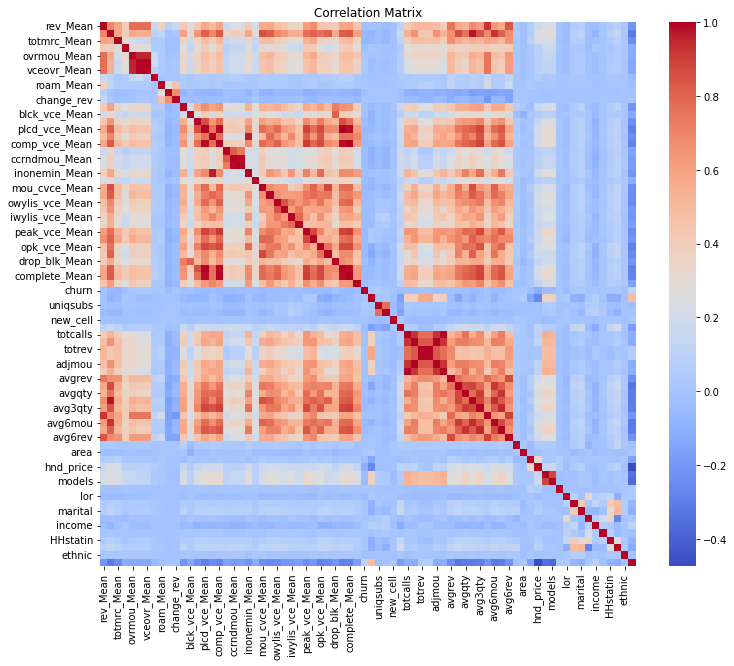

In [12]:
#Checking correlation with churn
df_dropped = df.drop(columns = list(to_drop), axis = 1)
corr = df_dropped.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [13]:
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_reduced)[:, 1]))

ROC-AUC Score: 0.6732227489123227


In [14]:
#Check using gridsearch to see what parameters are best
#This took about 5 minutes using all my cpu cores
param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, 
                           scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.625


In [15]:
#Quicker but not as accurate, took about 1 minute
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist,
                                   n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 189}


In [16]:
#Check using gridsearch to see what parameters are best
#This took about 5 minutes using all my cpu cores
param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search_reduced = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, 
                           scoring='accuracy', n_jobs=-1)
grid_search_reduced.fit(X_train_reduced, y_train)
print("Best parameters:", grid_search_reduced.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search_reduced.best_score_))

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.625


In [17]:
#Fitting a model with the best paramaters
model = RandomForestClassifier(**random_search.best_params_, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=189, random_state=42)

In [18]:
reduced_model = RandomForestClassifier(**grid_search_reduced.best_params_, random_state=42)
reduced_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [19]:
predictions_reduced = reduced_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.6222
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.63      0.63     10021
           1       0.62      0.61      0.62      9979

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



In [20]:
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.63165
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.61      0.62     10021
           1       0.63      0.65      0.64      9979

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



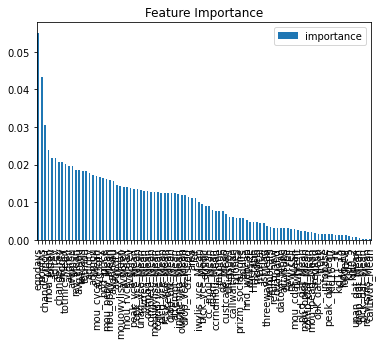

In [21]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

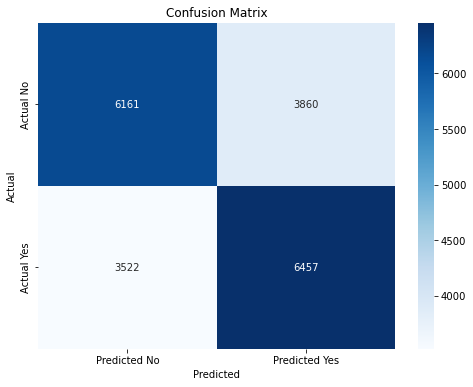

In [22]:
cm_reduced = confusion_matrix(y_test, predictions_reduced)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_reduced, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

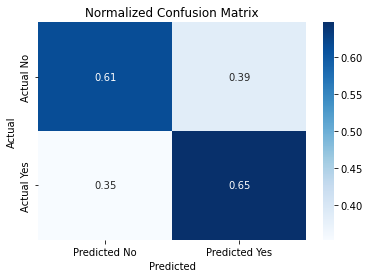

In [23]:
cm_normalized = cm_reduced.astype('float') / cm_reduced.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_reduced))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63     10021
           1       0.63      0.65      0.64      9979

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000



In [25]:
#Lets try some boosting techniques:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

boosted = GradientBoostingClassifier()
boosted_param = GridSearchCV(boosted, param_grid, cv=3, scoring='accuracy', verbose = 3, n_jobs=-1)
boosted_param.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=3)

In [26]:
print("Best Parameters:", boosted_param.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


Test Accuracy: 0.6423
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64     10021
           1       0.64      0.66      0.65      9979

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



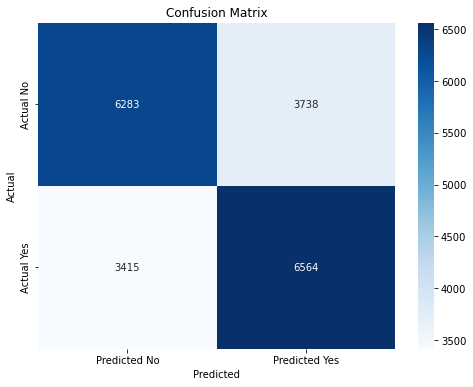

In [27]:
best_model = boosted_param.best_estimator_
predictions = best_model.predict(X_test_reduced)

test_accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

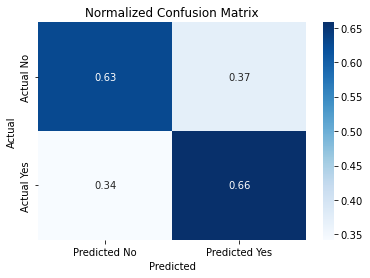

In [28]:
cm_normalized = cm.astype('float') / cm_reduced.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()

In [31]:
importances = best_model.feature_importances_
feature_names = X_train_reduced.columns
feature_importance_dict = dict(zip(feature_names, importances))
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print(feature_importances_df)

             Feature  Importance
72           eqpdays    0.147598
36            months    0.099507
9         change_mou    0.065076
1           mou_Mean    0.061169
2        totmrc_Mean    0.046403
10        change_rev    0.035574
59         hnd_price    0.033309
49            avgqty    0.026987
40          crclscod    0.025677
48            avgmou    0.020907
47            avgrev    0.018059
22     mou_cvce_Mean    0.017998
0           rev_Mean    0.017558
37          uniqsubs    0.016434
63               lor    0.014503
11     drop_vce_Mean    0.013086
4        ovrmou_Mean    0.012737
71            ethnic    0.012726
5        ovrrev_Mean    0.011054
31     mou_opkv_Mean    0.010555
55           avg6rev    0.010328
57              area    0.010130
25   mouowylisv_Mean    0.009844
41          totcalls    0.009829
32     drop_blk_Mean    0.009746
29     mou_peav_Mean    0.009658
43            totrev    0.009205
51           avg3qty    0.009184
20     inonemin_Mean    0.008461
30      op